# Banking research analysis 2

Research questions:
 - is the transmission of ECB conventional monetary policy effective on banks’ volumes and banks’ rates since 2014?
 - is there a time lag?

## Importing dependecies

In [205]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import statsmodels.api as sm
from matplotlib import style
from statsmodels.tsa.seasonal import seasonal_decompose

In [206]:
# Setting style for every plot
plt.style.use('seaborn')

# or 'ggplot' style

/var/folders/y1/w89cf9v14zb9dn4l_yrgzfth0000gn/T/ipykernel_1067/3282746314.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


## Data preparation

The data was gathered from the Statistical Data Warehouse webite affiliated with the ECB. After some considerations we decided to extract data relative to:
- MRO
- Cost of borrowings (< and > 1 year maturity), calculated by weighting volume with a moving average
- Loan rates applied to Non Financial Corporations, Households for House purchases and Households for consumption
- Banks volumes of loans
- Banks volumes of deposits
- Banks' lending margins over euro area countries
All data is extracted in general for Euro Area expect the lending margins that also refer to specific Eu countries. 

After some excel modifications and merging the datasets, we ended up with two cleaned datasets: one containing the first 5 parts from above (110 rows x 21 columns), and one containing the lending margins (110 rows x 20 columns).

Both datasets are indexed through date: we gathered monthly data from January 2014 up until February 2023.

In [207]:
df = pd.read_excel('datasets/MRO.xls') #loading MRO Data

In [208]:
df.drop(0, 0, inplace=True)

/var/folders/y1/w89cf9v14zb9dn4l_yrgzfth0000gn/T/ipykernel_1067/2701482825.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(0, 0, inplace=True)


In [209]:
df = df.iloc[::-1,].reset_index(drop=True)
df.rename(columns={'Value' : 'MRO'}, inplace=True)
df

Date   MRO
0   2014-01-01  0.25
1   2014-02-01  0.25
2   2014-03-01  0.25
3   2014-04-01  0.25
4   2014-05-01  0.25
..         ...   ...
105 2022-10-01  2.00
106 2022-11-01  2.00
107 2022-12-01  2.50
108 2023-01-01  3.00
109 2023-02-01  3.00

[110 rows x 2 columns]

In [210]:
df_rates = pd.read_excel('datasets/LoansRates_outstandings.xls', sheet_name='Sheet1')
df_rates = df_rates.iloc[::-1,].reset_index(drop=True)
# df_rates

In [211]:
df_cob = pd.read_excel('datasets/cob_movingaverage.xls', sheet_name='Sheet1')
df_cob = df_cob.iloc[::-1,].reset_index(drop=True)
# df_cob

In [212]:
df_loans = pd.read_excel('datasets/Volumes_loans.xls', sheet_name= 'Sheet1')
df_loans = df_loans.iloc[::-1,].reset_index(drop=True)
# df of volumes for loans

In [213]:
df_deposits = pd.read_excel('datasets/Volumes_deposits.xls', sheet_name= 'Sheet1')
df_deposits = df_deposits.iloc[::-1,].reset_index(drop=True)
# df of volumes for deposits

In [214]:
data = pd.concat([df, df_cob.iloc[:, 1:], df_rates.iloc[:, 1:], df_loans.iloc[:, 1:], df_deposits.iloc[:, 1:]], axis=1)
data.head()
# data for volumes in million of euros
# MRO, Cob, and rates are all in percentages

Date   MRO  Cob, up to 1 year  Cob, over 1 year  \
0 2014-01-01  0.25               2.95              3.22   
1 2014-02-01  0.25               2.95              3.18   
2 2014-03-01  0.25               2.97              3.16   
3 2014-04-01  0.25               2.96              3.13   
4 2014-05-01  0.25               2.90              3.06   

   Rates to NFC loans, up to 1 year  Rates to NFC loans, over 1 year  \
0                              3.69                             3.17   
1                              3.66                             3.21   
2                              3.64                             3.18   
3                              3.65                             3.18   
4                              3.60                             3.17   

   Rates for house purchases, up to 1 year  \
0                                     3.31   
1                                     3.30   
2                                     3.30   
3                                     3.37   
4                                     3.33   

   Rates for house purchases, over 1 year  \
0                                    3.29   
1                                    3.35   
2                                    3.32   
3                                    3.30   
4                                    3.28   

   Rates for consumptions and others, up to 1 year  \
0                                             7.62   
1                                             7.67   
2                                             7.64   
3                                             7.55   
4                                             7.54   

   Rates for consumptions, over 1 year  ...  \
0                                 5.01  ...   
1                                 5.09  ...   
2                                 5.01  ...   
3                                 5.03  ...   
4                                 5.01  ...   

   Loans for house purchases, up to 1 year  \
0                                 12198.65   
1                                 11580.23   
2                                 12564.71   
3                                 12458.21   
4                                 12170.53   

   Loans for house purchases, over 1 year  \
0                                29437.53   
1                                27872.59   
2                                29067.69   
3                                31706.92   
4                                29756.39   

   Loans for households consumptions, up to 1 year  \
0                                          2688.41   
1                                          2377.54   
2                                          2650.09   
3                                          2557.98   
4                                          2423.85   

   Loans for households consumptions, over 1 year  \
0                                        12021.54   
1                                        12072.53   
2                                        13465.63   
3                                        14040.44   
4                                        13575.69   

   Deposits of NFC, Up to 1 year  Deposits of NFC, over 1 and up to 2 years  \
0                      111432.62                                    4705.88   
1                       96006.44                                    3691.90   
2                       99171.82                                    3377.05   
3                      114382.59                                    3649.89   
4                       99891.56                                    3600.78   

   Deposits of NFC, over 2 years  Deposits of Households, up to 1 year  \
0                        4204.96                              81815.73   
1                        3473.76                              67314.52   
2                        2725.79                              66901.36   
3                        2937.89                              70771.75   
4                        24

In [215]:
data['Date'] = data['Date'].apply(pd.to_datetime)
data.set_index('Date',inplace=True)
data.head()

MRO  Cob, up to 1 year  Cob, over 1 year  \
Date                                                    
2014-01-01  0.25               2.95              3.22   
2014-02-01  0.25               2.95              3.18   
2014-03-01  0.25               2.97              3.16   
2014-04-01  0.25               2.96              3.13   
2014-05-01  0.25               2.90              3.06   

            Rates to NFC loans, up to 1 year  Rates to NFC loans, over 1 year  \
Date                                                                            
2014-01-01                              3.69                             3.17   
2014-02-01                              3.66                             3.21   
2014-03-01                              3.64                             3.18   
2014-04-01                              3.65                             3.18   
2014-05-01                              3.60                             3.17   

            Rates for house purchases, up to 1 year  \
Date                                                  
2014-01-01                                     3.31   
2014-02-01                                     3.30   
2014-03-01                                     3.30   
2014-04-01                                     3.37   
2014-05-01                                     3.33   

            Rates for house purchases, over 1 year  \
Date                                                 
2014-01-01                                    3.29   
2014-02-01                                    3.35   
2014-03-01                                    3.32   
2014-04-01                                    3.30   
2014-05-01                                    3.28   

            Rates for consumptions and others, up to 1 year  \
Date                                                          
2014-01-01                                             7.62   
2014-02-01                                             7.67   
2014-03-01                                             7.64   
2014-04-01                                             7.55   
2014-05-01                                             7.54   

            Rates for consumptions, over 1 year  Loans to NFC, up to 1 year  \
Date                                                                          
2014-01-01                                 5.01                   177949.29   
2014-02-01                                 5.09                   148452.00   
2014-03-01                                 5.01                   170872.68   
2014-04-01                                 5.03                   179919.58   
2014-05-01                                 5.01                   154976.81   

            ...  Loans for house purchases, up to 1 year  \
Date        ...                                            
2014-01-01  ...                                 12198.65   
2014-02-01  ...                                 11580.23   
2014-03-01  ...                                 12564.71   
2014-04-01  ...                                 12458.21   
2014-05-01  ...                                 12170.53   

            Loans for house purchases, over 1 year  \
Date                                                 
2014-01-01                                29437.53   
2014-02-01                                27872.59   
2014-03-01                                29067.69   
2014-04-01                                31706.92   
2014-05-01                                29756.39   

            Loans for households consumptions, up to 1 year  \
Date                                                          
2014-01-01                                          2688.41   
2014-02-01                                          2377.54   
2014-03-01                                          2650.09   
2014-04-01                                          2557.98   
2014-05-01                                          2423.85   

            Loans for households consumpti

In [216]:
margins = pd.read_excel('datasets/banks_lending_margins.xls', sheet_name='Sheet1')
margins = margins.iloc[::-1,].reset_index(drop=True)

margins['Date'] = margins['Date'].apply(pd.to_datetime)
margins.set_index('Date',inplace=True)
margins.head()

Austria  Belgium  Cyprus  Germany  Estonia   Spain  Finland  \
Date                                                                      
2014-01-01   1.3609   1.4896  3.3124   1.8328   2.2141  2.3167   1.2122   
2014-02-01   1.3404   1.5041  2.7681   1.8280   2.5632  2.4728   1.3086   
2014-03-01   1.3017   1.5139  2.8993   1.9497   2.6848  2.5406   1.4667   
2014-04-01   1.2752   1.5406  2.8666   1.8342   2.7590  2.6922   1.2043   
2014-05-01   1.3140   1.5722  2.8086   1.8328   2.3384  2.6095   1.1124   

            France  Greece  Ireland   Italy  Lithuania  Luxembourg  Latvia  \
Date                                                                         
2014-01-01  1.4653  2.6470   2.5885  1.6463     2.4456      1.4014  3.4374   
2014-02-01  1.4944  2.3820   2.8328  1.6513     2.3696      1.4727  3.7921   
2014-03-01  1.4645  2.4275   2.9685  1.6675     2.1816      1.4459  3.2930   
2014-04-01  1.4104  3.7878   2.8713  1.7406     2.4896      1.4042  3.9488   
2014-05-01  1.4790  2.8461   2.8505  1.5861     2.3504      1.3984  2.5767   

             Malta  Netherlands  Portugal  Slovenia  Slovakia  EU_average  
Date                                                                       
2014-01-01  1.6537       2.3175    3.5345    2.6039    2.2076    2.194074  
2014-02-01  2.2154       2.3583    3.3568    3.1184    1.9953    2.253911  
2014-03-01  2.5365       2.4864    3.8627    3.1681    2.0317    2.310032  
2014-04-01  1.8695       2.3292    3.7964    3.4996    2.1213    2.391621  
2014-05-01  2.3807       2.2962    3.8959    3.3832    1.9983    2.243653

In [217]:
margins.shape

(110, 20)

In [218]:
ind_dict = {}
for i, col in enumerate(data.columns):
    ind_dict[i] = col
ind_dict

{0: 'MRO',
 1: 'Cob, up to 1 year',
 2: 'Cob, over 1 year',
 3: 'Rates to NFC loans, up to 1 year',
 4: 'Rates to NFC loans, over 1 year',
 5: 'Rates for house purchases, up to 1 year',
 6: 'Rates for house purchases, over 1 year',
 7: 'Rates for consumptions and others, up to 1 year',
 8: 'Rates for consumptions, over 1 year',
 9: 'Loans to NFC, up to 1 year',
 10: 'Loans to NFC, over 1 year',
 11: 'Loans for house purchases, up to 1 year',
 12: 'Loans for house purchases, over 1 year',
 13: 'Loans for households consumptions, up to 1 year',
 14: 'Loans for households consumptions, over 1 year',
 15: 'Deposits of NFC, Up to 1 year',
 16: 'Deposits of NFC, over 1 and up to 2 years',
 17: 'Deposits of NFC, over 2 years',
 18: 'Deposits of Households, up to 1 year',
 19: 'Deposits of Households, over 1 and up to 2 years',
 20: 'Deposits of Households, over 2 years'}

## Rates overview and analysis

In [219]:
# general overview of all features

fig, ax = plt.subplots(3, 3, figsize=(15, 7))
ax = ax.flatten()                          # realy useful: n-dim -> uni-dim array (could also use ax.ravel())
for i, col in enumerate(data.columns[:9]):
    ax[i].plot(data.index, data[col])
    ax[i].set_title(col)
    ax[i].set_xlabel('Years')
    
    ax[i].set_ylabel('Rate value (%)')
    
plt.tight_layout()                          # to avoid overlapping of subplots
plt.show()

In [220]:
margins_MRO_ratio = margins['EU_average']/data['MRO']
margins_MRO_ratio

Date
2014-01-01    8.776295
2014-02-01    9.015642
2014-03-01    9.240126
2014-04-01    9.566484
2014-05-01    8.974611
                ...   
2022-10-01    1.064376
2022-11-01    1.136721
2022-12-01    0.916027
2023-01-01    0.753533
2023-02-01    0.740812
Length: 110, dtype: float64

/var/folders/y1/w89cf9v14zb9dn4l_yrgzfth0000gn/T/ipykernel_1067/678559536.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
/var/folders/y1/w89cf9v14zb9dn4l_yrgzfth0000gn/T/ipykernel_1067/678559536.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.1%}'.format(x) for x in vals])


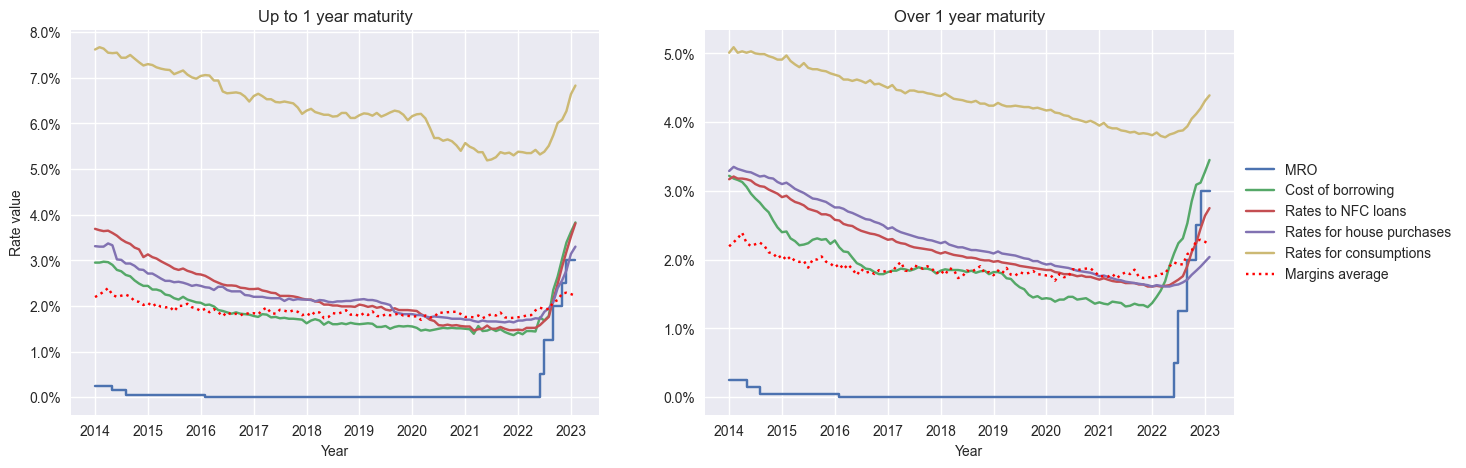

In [221]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.step(data.index, data.loc[:,'MRO'], label='MRO')
ax1.plot(data.loc[:, list(data.columns[1:9:2])], 
         label = ['Cost of borrowing', 'Rates to NFC loans','Rates for house purchases','Rates for consumptions'])
ax1.plot(margins['EU_average'], label ='Margins average', color = 'red', linestyle=':')
ax1.set_ylabel('Rate value')
ax1.set_xlabel('Year')
ax1.set_title('Up to 1 year maturity')
vals = ax1.get_yticks()/100
ax1.set_yticklabels(['{:,.1%}'.format(x) for x in vals])

ax2.step(data.index, data.loc[:,'MRO'], label='MRO')
ax2.plot(data.loc[:, data.columns[2:9:2]],
         label = ['Cost of borrowing', 'Rates to NFC loans','Rates for house purchases','Rates for consumptions'])
# ax2.set_ylabel('Rate value')
ax2.plot(margins['EU_average'], label ='Margins average', color = 'red', linestyle=':')
ax2.set_xlabel('Year')
ax2.set_title('Over 1 year maturity')
vals = ax2.get_yticks()/100
ax2.set_yticklabels(['{:,.1%}'.format(x) for x in vals])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# general title on canva: 'MRO and Rates over time'

One important observation we can draw from the two plots above is that there is a higher time lag (time for the adjustment of the rates as the `MRO` move) during periods of decrease in `MRO`, while the time lag is clearly shorter during periods of increase in `MRO`. 

From the plot it appear to us that banks lending rates reacted faster to changes in MRO in the last period (2022 on) compared to the period of low rate from 2014 to 2020.

But why?
First, we may want to highlight that when interest rates rise banks on average are more profitable. One indicator for that in our plot is the `margins average`, a measure of the average margins of banks in the Euro area. It's clear that when `MRO` increase also the margins increase (i.e. from mid 2022 on) and when `MRO` decrease and remain constant (i.e. from 2014 to mid 2022) also the margins decrease and remain constant. What is interesting from this observation however is to connect this fact to the time lag we were discussing before.

During the long period of decrease and stagnation of `MRO` (and margins) from 2014 to 2022 banks decreased gradually their rates and as a consequence the time lag was greater. This in our opinion is due to the fact that banks have low incentive to decrease their lending rate that would consequently decrease their margins in the lending activity. Also, the decrease is subject to a competitivness between banks: ideally they all want to lower the rates to steal customers to the competitors, but in a certain way they may want also to collude in order to keep the profits higher for all of them, and not approach closer and closer the MRO. 
On the other side, during periods of increase (or steep increase, as in our case for the period 2022 on) banks have a incentive to react faster by increasing their rates. Mainly for the reason we presented above, with higher rates they can be more profitable and increase their margins. Secondly, they have the urge to do so, since higher `MRO` impact negatively on their results and without incresing their rates they would take losses. So this are the reasons for the heterogenous time lag we can observe from the plot. 

Finally we found a correlation of 0.54 between `MRO` and `average margins` that confirms that positive changes in `MRO` raise the banks average margin on lending activity. 

In [222]:
# Without RATES FOR CONSUMPTIONS (plot is clearer, same scale)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.step(data.index, data.loc[:,'MRO'], label='MRO', where = 'post')
ax1.plot(data.loc[:, list(data.columns[1:7:2])], 
         label = ['Cost of borrowing', 'Rates to NFC loans','Rates for house purchases'])
ax1.plot(margins['EU_average'], label ='Margins average', color = 'red', linestyle=':')
ax1.set_ylabel('Rate value')
ax1.set_xlabel('Year')
ax1.set_title('Up to 1 year maturity')
vals = ax1.get_yticks()/100
ax1.set_yticklabels(['{:,.1%}'.format(x) for x in vals])

ax2.step(data.index, data.loc[:,'MRO'], label='MRO', where = 'post')
ax2.plot(data.loc[:, data.columns[2:7:2]],
         label = ['Cost of borrowing', 'Rates to NFC loans','Rates for house purchases'])
# ax2.set_ylabel('Rate value')
ax2.plot(margins['EU_average'], label ='Margins average', color = 'red', linestyle=':')
ax2.set_xlabel('Year')
ax2.set_title('Over 1 year maturity')
vals = ax2.get_yticks()/100
ax2.set_yticklabels(['{:,.1%}'.format(x) for x in vals])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

/var/folders/y1/w89cf9v14zb9dn4l_yrgzfth0000gn/T/ipykernel_1067/2671754457.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
/var/folders/y1/w89cf9v14zb9dn4l_yrgzfth0000gn/T/ipykernel_1067/2671754457.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.1%}'.format(x) for x in vals])


An MRO rate of 0% means that banks no longer have to pay fees if they deposit their excess money into the central bank!! The pros to society in an era of low rates (0% in this case) are that there is a strong incentive to borrow and use those funds for future projects. A potential drawback is that firms might borrow more than they actually need and invest in projects which are riskier than if interest rates were higher.

Also, correlation between MRO and Average margins is 0.54 -> confirms that positive changes in MRO raise the banks average margin on lending activity. 


## Periods of interest - Rates

In [281]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.step(data.loc['2022-01-01':'2023-02-01', :].index, data.loc['2022-01-01':'2023-02-01', 'MRO'], label='MRO', where = 'post')
ax1.plot(data.loc['2022-01-01':'2023-02-01', list(data.columns[1:7:2])], 
         label = ['Cost of borrowing', 'Rates to NFC loans','Rates for house purchases'])
ax1.plot(margins.loc['2022-01-01':'2023-02-01', 'EU_average'], label = 'Average margins', color = 'red', linestyle=':')
ax1.set_ylabel('Rate value')
ax1.set_xlabel('Year-month')
ax1.set_title('Up to 1 year maturity')
vals = ax1.get_yticks()/100
ax1.set_yticklabels(['{:,.1%}'.format(x) for x in vals])

ax2.step(data.loc['2022-01-01':'2023-02-01', :].index, data.loc['2022-01-01':'2023-02-01', 'MRO'], label='MRO', where = 'post')
ax2.plot(data.loc['2022-01-01':'2023-02-01', data.columns[2:7:2]], 
         label = ['Cost of borrowing', 'Rates to NFC loans','Rates for house purchases'])
ax2.plot(margins.loc['2022-01-01':'2023-02-01', 'EU_average'], label = 'Average margins', color = 'red', linestyle=':')
ax2.set_ylabel('Rate value')
ax2.set_xlabel('Year-month')
ax2.set_title('Over 1 year maturity')
vals = ax2.get_yticks()/100
ax2.set_yticklabels(['{:,.1%}'.format(x) for x in vals])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

/var/folders/y1/w89cf9v14zb9dn4l_yrgzfth0000gn/T/ipykernel_1067/1699908942.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
/var/folders/y1/w89cf9v14zb9dn4l_yrgzfth0000gn/T/ipykernel_1067/1699908942.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.1%}'.format(x) for x in vals])


By looking at this plot, is clear how rates have immediately reacted to the rapid change during last year of `MRO` rate. However, even if the presented rates showed a greater sensitivity to the market changes than the one belonging to the period that has anticipated the growth of `MRO`, in our opinon there is still room for an icnrease in some indicators such as the `Rate for House purchases` and `Rates to NFC loans` with over 1 year maturity. 
This indicators infact, during the end of last quarter of 2022 and the beginning of first quarter of 2023, went below the value of `MRO`, stating that banks are granting this loans at a rate below the one they can borrow money with 1 week maturity from the ECB. What this means? Banks are offering medium-long term to both households and NFC at a competitive price and with a negative margin. This could be analyzed further, under our scope there could be two reasons:
- Banks are forecasting a future decrease in `MRO` rates, that would probably happens only with a steady decrease in the inflation or inflation expectations. 
- Banks want to overcome the enormous and historically maximum decrease in the volumes of households loans by granting long term loans (that we recall present always smaller rates that short term loans) at a competitive rate (also, in a competitive market dynamic) that when fixed would guarantee a strong inflow of money in the future (only in presence of lower future `MRO` rates and inflation decrease)

In both cases, it's clear how the indicators we cited before are subject to a greater time-lag in the changes of `MRO` than other indicators. 

Furthermore, this help to explain the subtle decrease in the `Margins average` that is noticeable from november 2022: the grant of new loans (for house purchase and to NFC) at rates below `MRO` impacted negatively by reducing the margins in the lending activity of the European banks. 

## Volumes - Loans and Deposits

In [225]:
# loans
data.columns[9:15]

Index(['Loans to NFC, up to 1 year', 'Loans to NFC, over 1 year',
       'Loans for house purchases, up to 1 year',
       'Loans for house purchases, over 1 year',
       'Loans for households consumptions, up to 1 year',
       'Loans for households consumptions, over 1 year'],
      dtype='object')

In [226]:
# deposits
data.columns[15:]

Index(['Deposits of NFC, Up to 1 year',
       'Deposits of NFC, over 1 and up to 2 years',
       'Deposits of NFC, over 2 years', 'Deposits of Households, up to 1 year',
       'Deposits of Households, over 1 and up to 2 years',
       'Deposits of Households, over 2 years'],
      dtype='object')

In [227]:
fig, ax = plt.subplots(4, 3, figsize=(13, 9))
ax = ax.flatten()                          # realy useful: n-dim -> uni-dim array (could also use ax.ravel())
for i, col in enumerate(data.columns[9:]):
    ax[i].plot(data.index, data[col])
    ax[i].set_title(col)
    ax[i].set_xlabel('Years')
    ax[i].set_ylabel('Millions of €') 
plt.tight_layout()                          # to avoid overlapping of subplots
plt.show()

For sure the deposits are more irregular than the loans.

Due to the large difference of scale, we have 2 options:
- plot multiple lines in single plots and showing the decompositions for the ts that are hard to analyze due to the scale;
- plot loans and deposits with different plots (as above) and commenting them.

I personally like more option 2.

### Option 1 - example

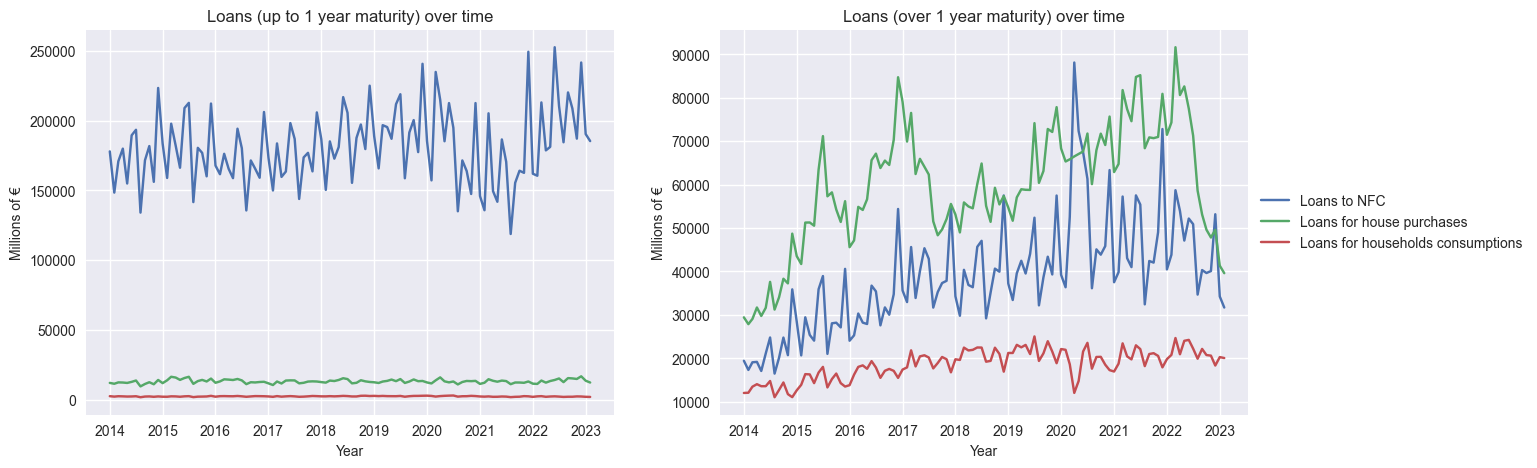

In [228]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(data.loc[:, data.columns[9:15:2]], 
        label = ['Loans to NFC','Loans for house purchases','Loans for households consumptions']) 
ax1.set_ylabel('Millions of €')
ax1.set_xlabel('Year')
ax1.set_title('Loans (up to 1 year maturity) over time')

ax2.plot(data.loc[:, data.columns[10:16:2]], 
        label = ['Loans to NFC', 'Loans for house purchases','Loans for households consumptions']) 
ax2.set_ylabel('Millions of €')
ax2.set_xlabel('Year')
ax2.set_title('Loans (over 1 year maturity) over time')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

<Axes: xlabel='Date'>

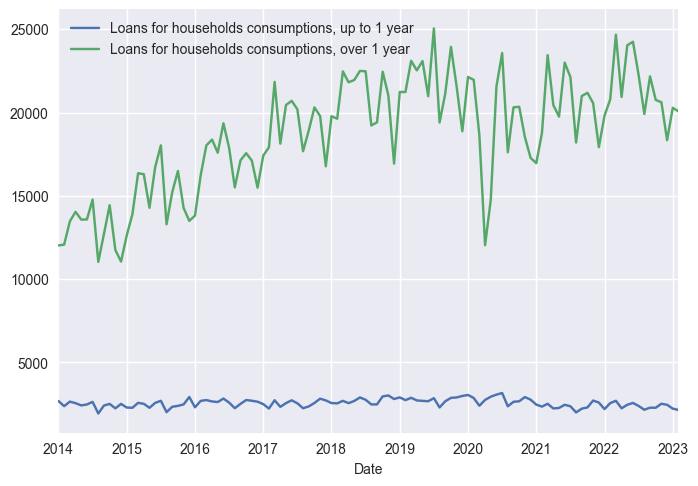

In [229]:
data.loc[:, data.columns[13:15]].plot() # change columns (take households consumptions)

here for example the green ts is more clear but the other is completely non sense, because in fact in correct scale it looks like the following, which is completely different.

In [230]:
data.loc[:, data.columns[13]].plot()

<Axes: xlabel='Date'>

### Option 2

In [231]:
fig, ax = plt.subplots(3, 2, figsize=(15, 7))
ax = ax.flatten()                          
for i, col in enumerate(data.columns[9:15]):
    ax[i].plot(data.index, data[col], color="red")
    ax[i].plot(data.rolling(window=12).mean()[col], color ="black", linestyle='dashed', alpha= 0.7, label="MA")     # adding MA with a rolling window of 1 year
    ax[i].set_title(col)
    ax[i].set_xlabel('Years')
    ax[i].set_ylabel('Millions of €')
    ax[i].legend()
plt.tight_layout()                          
plt.show()

This chart shows the performance of the loans issued from the banks to different types of clients. The black dashed line represents the moving average calculated with a lag of 12 months, this allows us to have a better look at the trend. In general we can say that it is almost null in all the cases since both the start and the end point are basically on the same value. At the same time, speaking about the seasonality is visible that it is so much clear in the case of loans rather than for deposits. 
The trend of the loans is related with the MRO with an inverse proportionality, since when the MRO has stayed equal to 0 (2014 - mid 2022) the volumes of the loans saw an increase while when the MRO passed the 0 all the volumes experienced a decrease. 
Almost all the time series has a seasonality that repeat itself every year. 
The interesting points we could emphasize are the steep decrease in loans to households for consumption purposes suddenly after the beginning of the COVID-19, this happened mainly because many people got layed off and were no more able to afford new loans, especially for goods like cars and in general for personal use. Another interesting point is the sharp increase in the loans to NFC over 1 year thanks to a convenient decrease in the cost of borrowing in the same time period, probably thanks to 

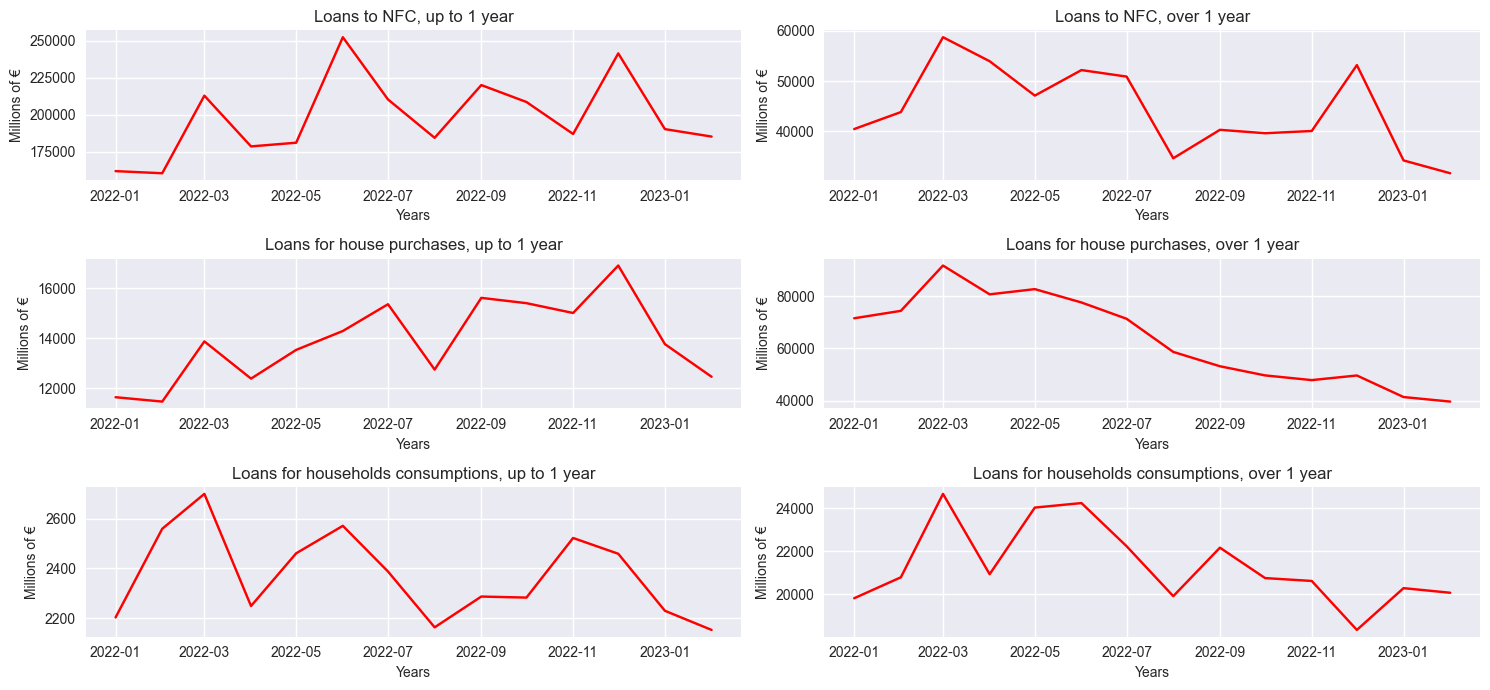

In [232]:
fig, ax = plt.subplots(3, 2, figsize=(15, 7))
ax = ax.flatten()                          
for i, col in enumerate(data.columns[9:15]):
    ax[i].plot(data.loc['2022-01-01':'2023-02-01', col], color="red")
    # ax[i].plot(data.loc['2022-01-01':'2023-02-01', :].index, data.loc['2022-01-01':'2023-02-01', col], color="red")
    ax[i].set_title(col)
    ax[i].set_xlabel('Years')
    ax[i].set_ylabel('Millions of €')
plt.tight_layout()                          
plt.show()

Here we analyze the period 2022-2023. All the types of loans reflected the change in MRO causing a general decrease in the volumes. The fact that the decrease is not immediate is due to the time lag that exists between the change in MRO and the change in loans volumes.

The very interesting behavior is the one of the loans for house purchases over 1 year: according to the ECB website the main reason of such a decrease is attributable mainly to the raise of interest rates, prospects of house pricing and a decrease in consumer confidence. These three reason are linked since an increase in rates cause an uncertain prospect in house pricing that in turn cause a decrease in consumer confidence since people are less willing to buy houses if they don't know the future price.
Another interesting thing we could say is that the actual decrease in demand is worse compared to the expected decrease. 

All the other type of loans remains mor eor less steady across this time period, since companies have always need of founding, like loans for households consumptions, that now after the COVID pandemic crisis 

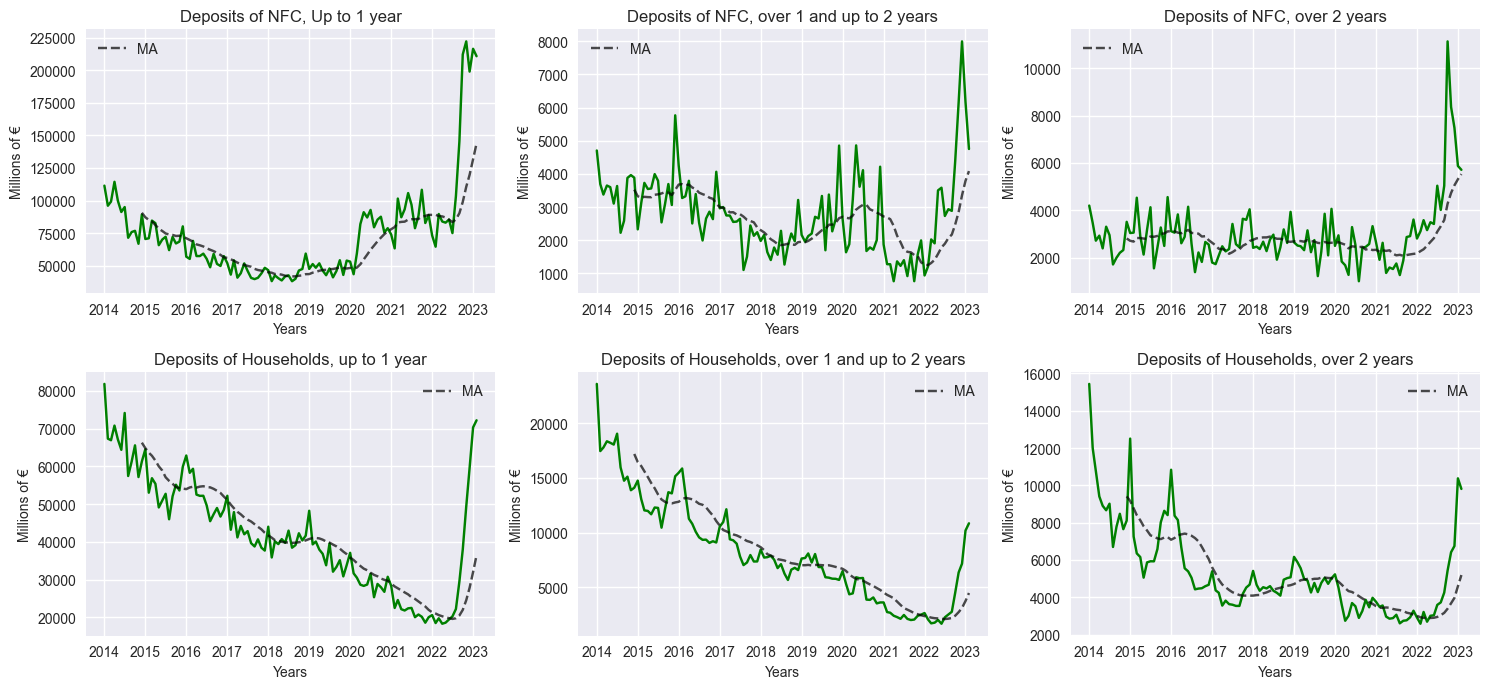

In [233]:
fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.flatten()                          
for i, col in enumerate(data.columns[15:]):
    ax[i].plot(data[col], color="green")
    ax[i].plot(data.rolling(window=12).mean()[col], color ="black", linestyle='dashed', alpha= 0.7, label="MA")     # adding MA with a rolling window of 1 year
    ax[i].set_title(col)
    ax[i].set_xlabel('Years')
    ax[i].set_ylabel('Millions of €')
    ax[i].legend()
plt.tight_layout()                         
plt.show()

Many things could be said from these 2 plots, added moving averages to skip the decomposition part (since it is the only thing we are interested in).

## Decompositions???

In [234]:
from statsmodels.tsa.seasonal import seasonal_decompose
# seasonal_decompose(data['col']).plot()
# add model if needed

## Correlations

The MRO is always present since it is the most important thing we want to analyze.

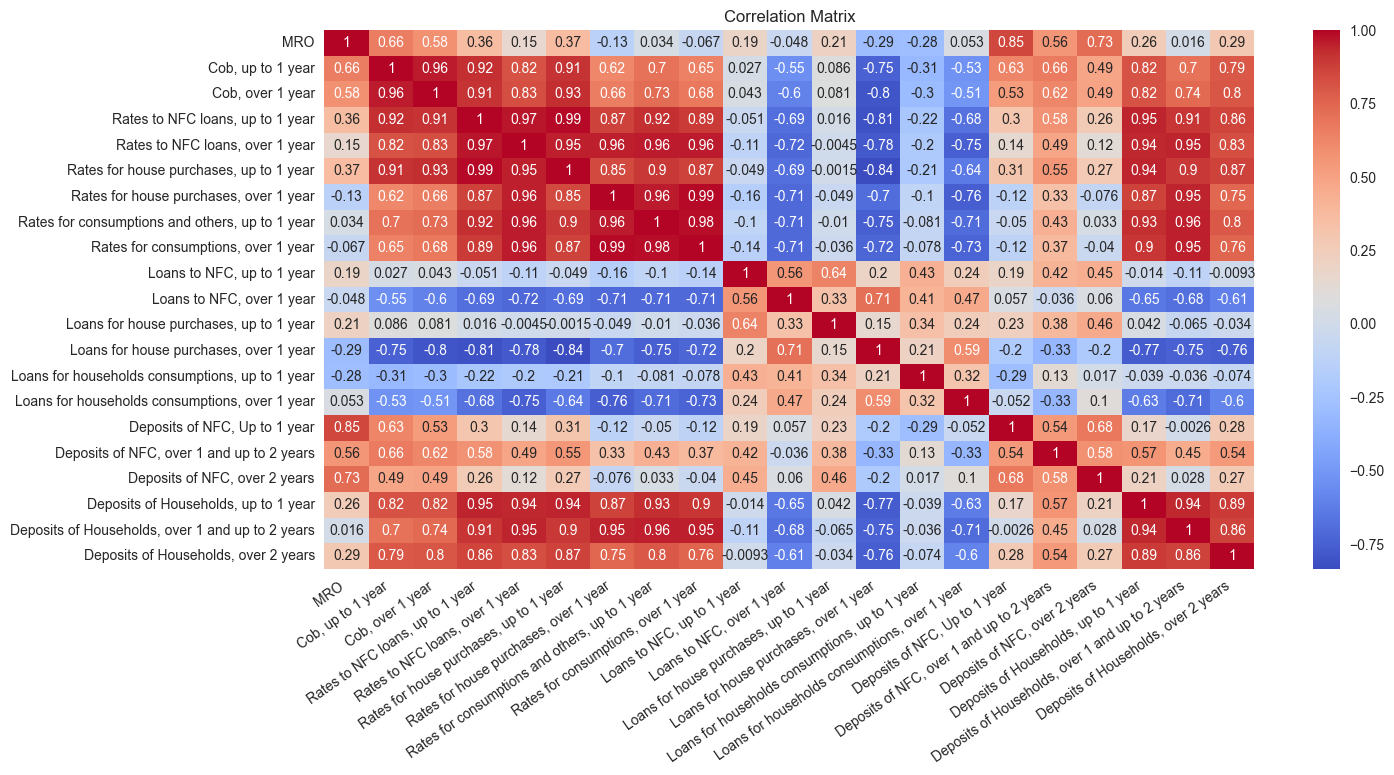

In [235]:
plt.figure(figsize= (15, 7))
corr_matrix = data.corr()
heatmap = sn.heatmap(corr_matrix, annot=True, cmap='coolwarm')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=35, ha='right')
plt.title('Correlation Matrix')
plt.show()


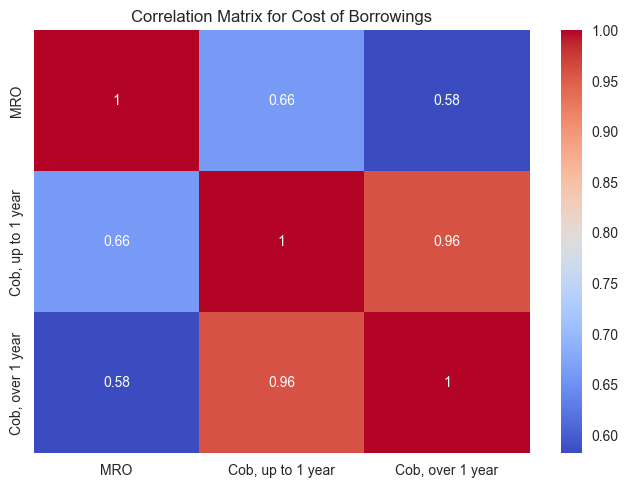

In [236]:
corr_matrix = data.iloc[:,:3].corr()
sn.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Cost of Borrowings')
plt.show()

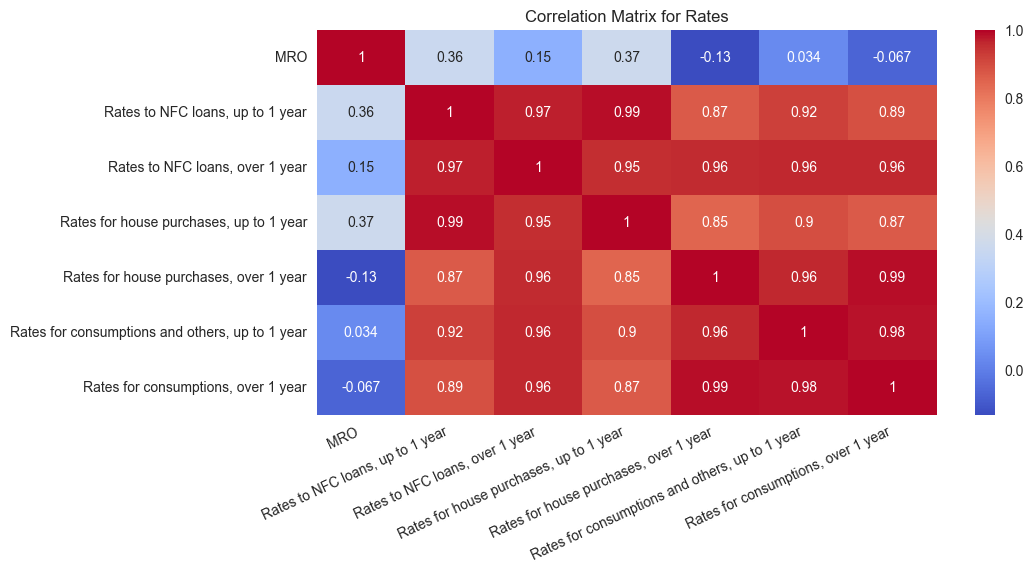

In [237]:
plt.figure(figsize= (10, 5))
corr_matrix = data.iloc[:, [0,3,4,5,6,7,8]].corr()
heatmap = sn.heatmap(corr_matrix, annot=True, cmap='coolwarm')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=25, ha='right')
plt.title('Correlation Matrix for Rates')
plt.show()

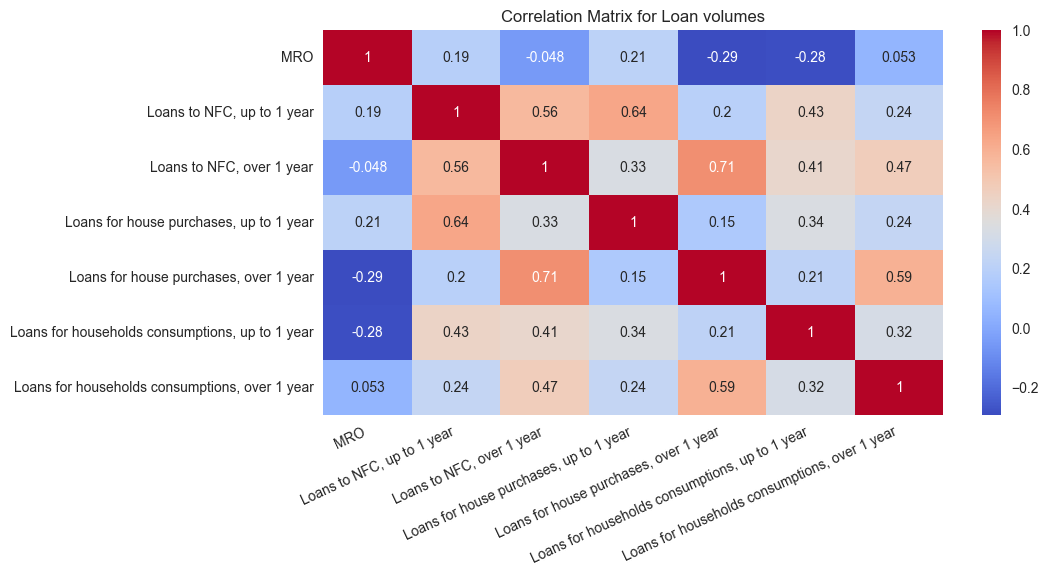

In [238]:
plt.figure(figsize= (10, 5))
corr_matrix = data.iloc[:, [0,9,10,11,12,13,14]].corr()
heatmap = sn.heatmap(corr_matrix, annot=True, cmap='coolwarm')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=25, ha='right')
plt.title('Correlation Matrix for Loan volumes')
plt.show()

In [239]:
plt.figure(figsize= (10, 5))
corr_matrix = data.iloc[:, [0,15,17,19,16,18,20]].corr()  # numbers are to reorder the columns
heatmap = sn.heatmap(corr_matrix, annot=True, cmap='coolwarm')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=25, ha='right')
plt.title('Correlation Matrix for Deposit volumes')
plt.show()

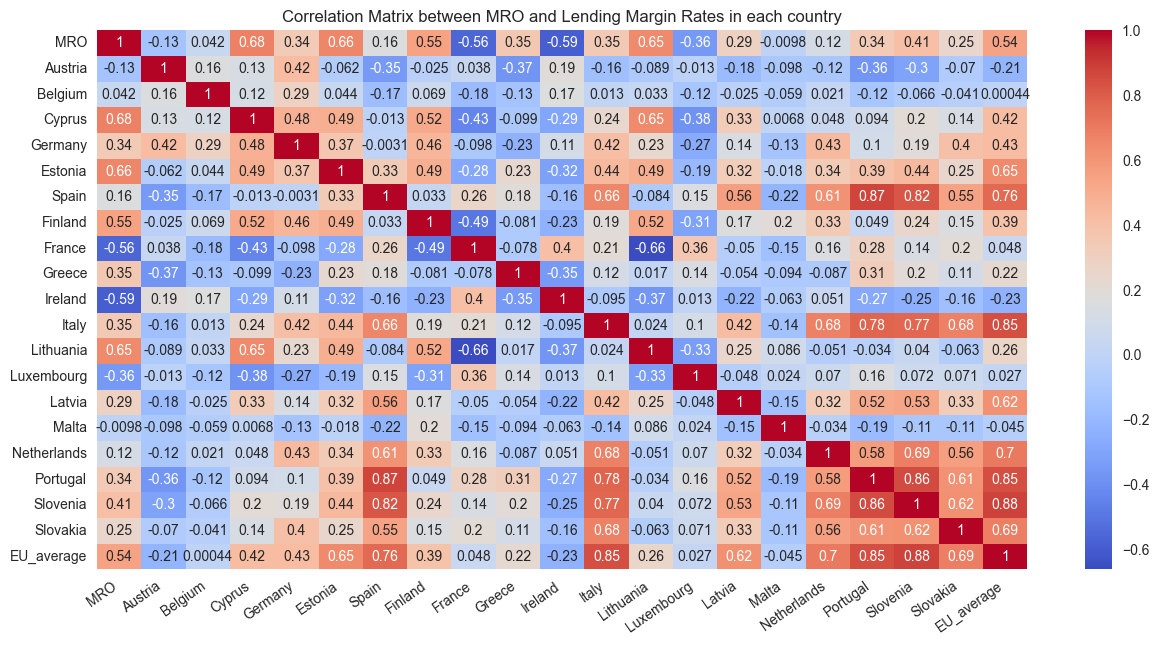

In [240]:
# only for curiosity

df_copy = pd.concat([data['MRO'], margins], axis=1)

plt.figure(figsize= (15, 7))
corr_matrix = df_copy.corr()
heatmap = sn.heatmap(corr_matrix, annot=True, cmap='coolwarm')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=35, ha='right')
plt.title('Correlation Matrix between MRO and Lending Margin Rates in each country')
plt.show()

# no interesting things apart from the .54 corr between MRO and EU_average

## Time-lag analysis

Cross-correlation analysis with max 2 years lag.

In [241]:
# lags = range(-12, 13)
lags = range(0, 24) 

In [242]:
# calculating correlations between MRO and all the other columns in turn
corr_functions = {}
for col in data.columns:
    if col != 'MRO':
        corr_functions[col] = [data['MRO'].corr(data[col].shift(lag)) for lag in lags]          # shifting for n months
# corr_functions
# these are NOT percentages!!
corr_functions.items()

dict_items([('Cob, up to 1 year', [0.6613606860898578, 0.5627422494438247, 0.43285878436592684, 0.2816229550265019, 0.1355590737784856, -0.0009934877937953761, -0.10472376910582305, -0.14733602628547632, -0.18802619502976214, -0.2292095251351553, -0.2364389283688155, -0.24373603063162272, -0.2506031432071372, -0.24783823476297354, -0.2510173753913415, -0.2419139264502961, -0.23722605041882594, -0.24068351715952213, -0.24419026779716274, -0.24926811777490837, -0.25472689079684147, -0.2564944615241316, -0.2585462685215098, -0.2714567913771984]), ('Cob, over 1 year', [0.5815441789857254, 0.5203494268771058, 0.45010278252670544, 0.3684530704015638, 0.26315651929129846, 0.1590526641009746, 0.07372307974977474, -0.0037630131422977824, -0.0853215118542123, -0.15498770210208135, -0.21158771043726093, -0.24849247203133468, -0.27540757320347403, -0.29327621861636827, -0.30136801475091, -0.3034615996373814, -0.3080681030238852, -0.3145013409392405, -0.32154643050978443, -0.3258499226732953, -0.32

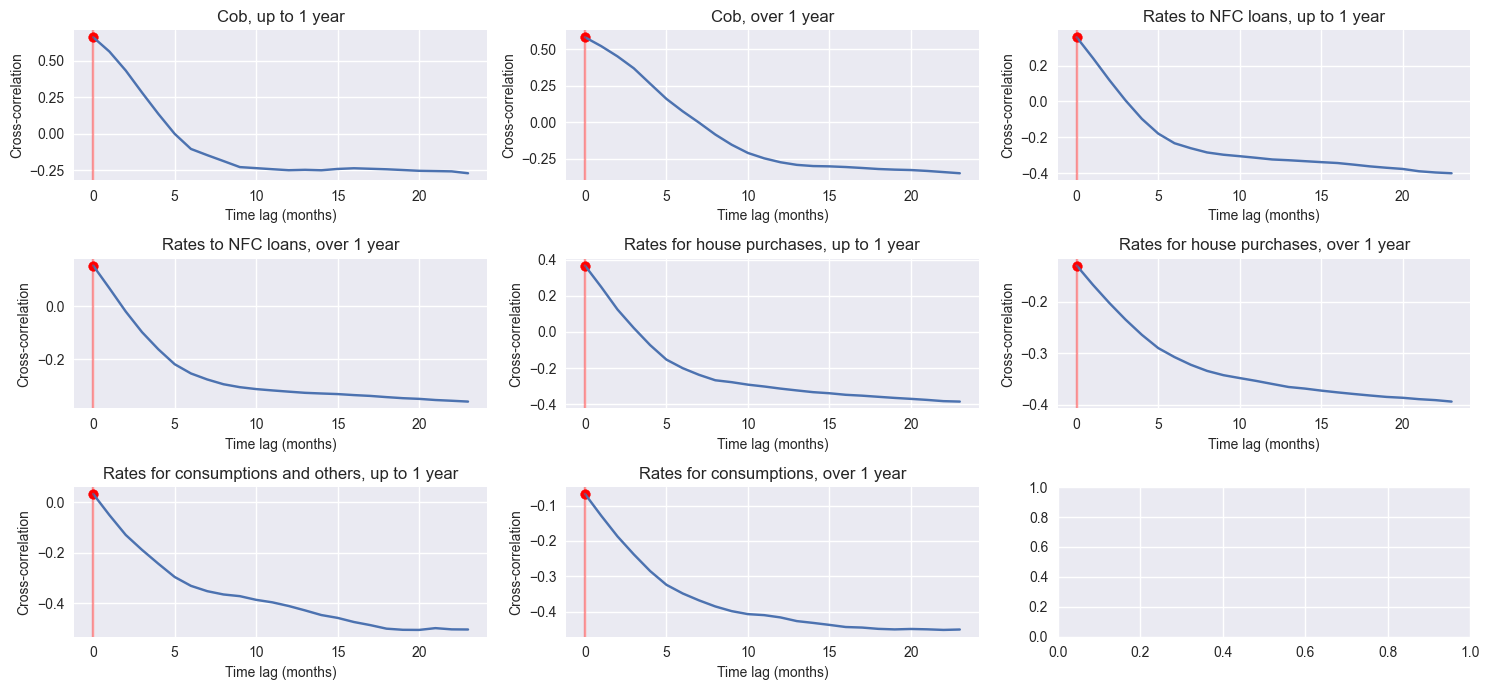

In [243]:
fig, axs = plt.subplots(3, 3, figsize=(15, 7))
axs = axs.flatten()
for i, (col, corr) in enumerate(list(corr_functions.items())[:8]):        # multiple indexing to put different indexes in the for loop
    axs[i].plot(lags, corr)
    axs[i].set_title(col)
    axs[i].set_xlabel('Time lag (months)')
    axs[i].set_ylabel('Cross-correlation')
    
    max_x = lags[np.argmax(corr)]
    max_y = np.max(corr)

    # Plot a point at the location of the maximum value
    axs[i].scatter(max_x, max_y, color='red')
    # Add a vertical line at the location of the maximum value
    axs[i].axvline(x=max_x, color='red', alpha = 0.4)
    

plt.tight_layout()
plt.show()

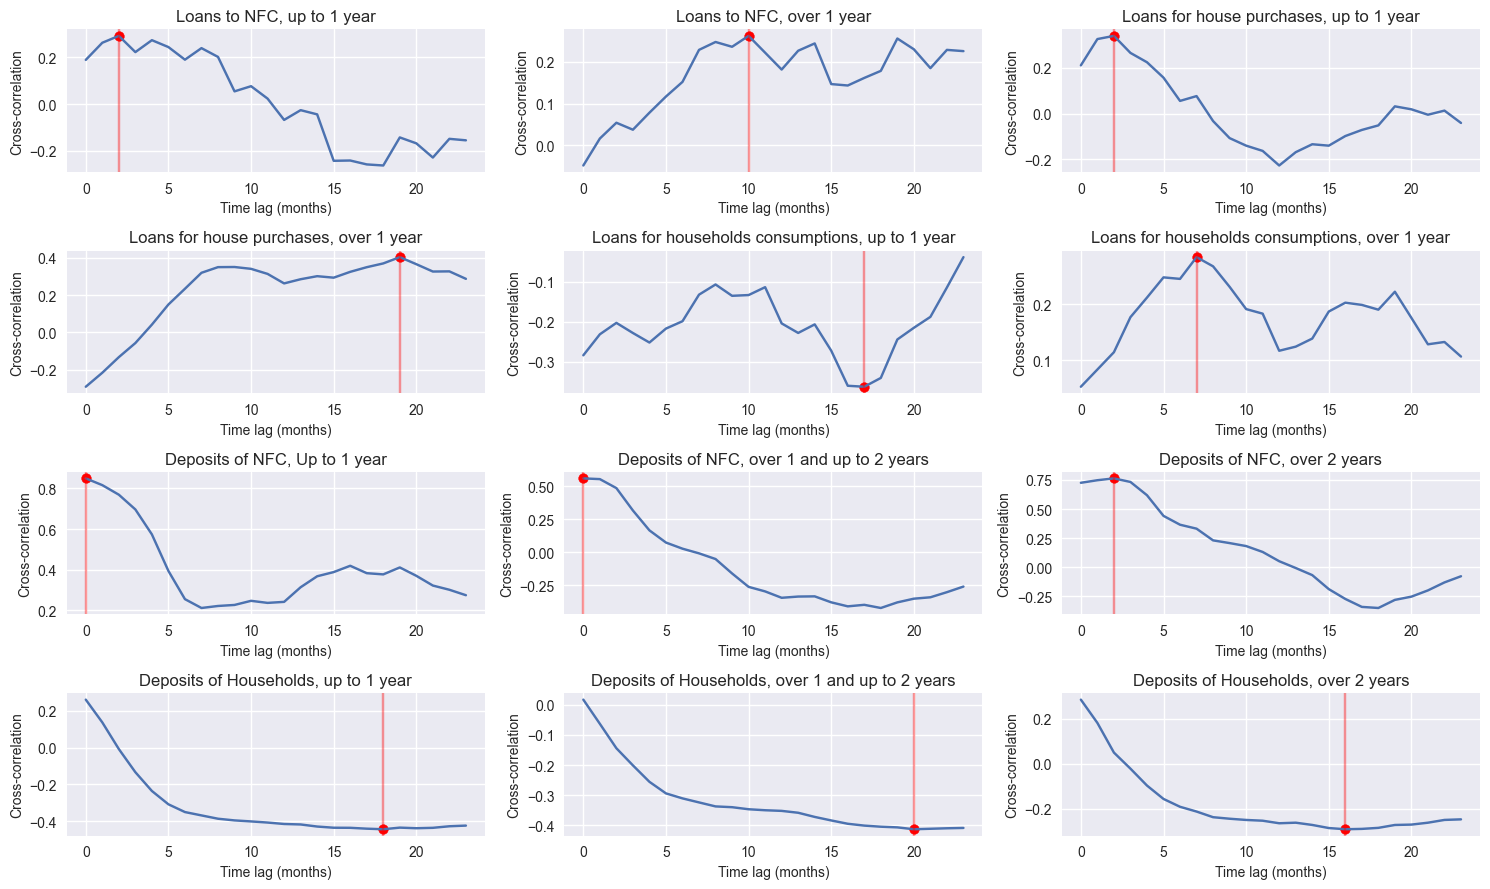

In [244]:
fig, axs = plt.subplots(4, 3, figsize=(15, 9))
axs = axs.flatten()
for i, (col, corr) in enumerate(list(corr_functions.items())[8:]):        # multiple indexing to put different indexes in the for loop
    axs[i].plot(lags, corr)
    axs[i].set_title(col)
    axs[i].set_xlabel('Time lag (months)')
    axs[i].set_ylabel('Cross-correlation')

    # Find the absolute maximum value of the cross-correlation 
    abs = [np.abs(ele) for ele in corr]
    if np.max(np.abs(abs)) > np.max(corr):
        max_y = np.min(corr)
        max_x = lags[np.argmin(corr)]
    else:
        max_y = np.max(corr)
        max_x = lags[np.argmax(corr)]

    # Plot a point at the location of the maximum value
    axs[i].scatter(max_x, max_y, color='red')
    # Add a vertical line at the location of the maximum value
    axs[i].axvline(x=max_x, color='red', alpha = 0.4)
    

plt.tight_layout()
plt.show()

The time lag analysis helps us to understand the timing of the transmission of monetary policy. The time lag analysis can thus help policymakers to evaluate the effectiveness and efficiency of their monetary policy tools and correct their policy if needed. 

The resulting plot shows the cross-correlation functions for each rate/volume in the dataset, with the time lag on the x-axis and the cross-correlation value on the y-axis. Positive time lags indicate that the MRO rate variations precede the changes in the other rate/volume, while negative time lags indicate that the changes in the other rate/volume precede the changes in the MRO rate.

If the correlation between MRO rate and a particular rate/volume shows a significant peak (drop) at a positive (negative) time lag, it indicates that the changes in MRO rate have a significant impact on the changes in the other rate/volume after (before) the lag. 

Obviously the magnitude and the direction of the time lag could provide some insights into the mechanisms of transmission of monetary policy, but we'll need more info to make some considerations. But for example, a significant positive time lag for loan rates may suggest that banks take some time to adjust their lending rates after the changes in MRO rate (maybe due to competitions? possible risks or costs?). Similarly, a significant negative time lag for loan volumes may indicate that changes in loan demand/supply may affect the MRO rate.

Observations:
- the red dots/lines are representing the biggest cross correlation among the 24 months of lag:
    - for the rates we just took the maximum value
    - for the volumes we plotted the biggest correlations in terms of absolute value
- in general time lag for rates is very small, cross-correlation decrease as the lag increases. So rates react faster to the increase in MRO (as we could expect)
- looks like that the deposits behave more or less like the rates in this sense
- for the loans there is heterogeneity among the cross-correlations but the time lag is indeed present (whether it is positive or negative) 

## Regressions

The regressions were computed not with a predictive purpose (not to predict the future values of the rates or the volumes nor to predict the MRO) but with the aim of studying and understanding the relationship between the rates/volumes and the MRO. These regressions will give us insights on the influence the MRO has on the rates/volumes: the significance will give us info if there is a relationship while the coefficient will give us info on the magnitude and the proportionality (direct/inverse) (sign).

The regression are computed with MRO as independent variable and in turn each rate/volume as dependent variable.

In [245]:
# setting independent variable
X = data['MRO']

In [246]:
print("With a p-value lower than 0.05, the MRO coeff is stat significant for:")
for col in data.columns:
    if col != 'MRO':
        y = data[col]
        model = sm.OLS(y, sm.add_constant(X)).fit(cov_type='HC3') # robust covariance matrix
        if model.pvalues['MRO'] < 0.05:
            print(f'{col} - Beta = {round(model.params[1],4)}')

With a p-value lower than 0.05, the MRO coeff is stat significant for:
Cob, up to 1 year - Beta = 0.6278
Cob, over 1 year - Beta = 0.5696
Rates to NFC loans, up to 1 year - Beta = 0.4215
Rates to NFC loans, over 1 year - Beta = 0.1328
Rates for house purchases, up to 1 year - Beta = 0.3037
Rates for house purchases, over 1 year - Beta = -0.1246
Loans for house purchases, over 1 year - Beta = -7448.482
Loans for households consumptions, up to 1 year - Beta = -128.3267
Deposits of NFC, Up to 1 year - Beta = 57292.6467
Deposits of NFC, over 1 and up to 2 years - Beta = 1250.505
Deposits of NFC, over 2 years - Beta = 1824.7102
Deposits of Households, up to 1 year - Beta = 7185.6966
Deposits of Households, over 2 years - Beta = 1244.6401


With a p-value lower than 0.05, the MRO beta coefficient is stat significant for:
- Cob, up to 1 year - Beta = 0.6278
- Cob, over 1 year - Beta = 0.5696
- Rates to NFC loans, up to 1 year - Beta = 0.4215
- Rates to NFC loans, over 1 year - Beta = 0.1328
- Rates for house purchases, up to 1 year - Beta = 0.3037
- Rates for house purchases, over 1 year - Beta = -0.1246
- Loans for house purchases, over 1 year - Beta = -7448.482
- Loans for households consumptions, up to 1 year - Beta = -128.3267
- Deposits of NFC, Up to 1 year - Beta = 57292.6467
- Deposits of Households, up to 1 year - Beta = 7185.6966
- Deposits of NFC, over 1 and up to 2 years - Beta = 1250.505
- Deposits of NFC, over 2 years - Beta = 1824.7102
- Deposits of Households, over 2 years - Beta = 1244.6401

In [247]:
print("With a p-value higher than 0.05, the MRO coeff is NOT stat significant for:")
for col in data.columns:
    if col != 'MRO':
        y = data[col]
        model = sm.OLS(y, sm.add_constant(X)).fit(cov_type='HC3')
        if model.pvalues['MRO'] > 0.05:
            print(f'{col} - p(oss) = {round(model.pvalues[1],4)}')

With a p-value higher than 0.05, the MRO coeff is NOT stat significant for:
Rates for consumptions and others, up to 1 year - p(oss) = 0.5751
Rates for consumptions, over 1 year - p(oss) = 0.2242
Loans to NFC, up to 1 year - p(oss) = 0.0667
Loans to NFC, over 1 year - p(oss) = 0.497
Loans for house purchases, up to 1 year - p(oss) = 0.1688
Loans for households consumptions, over 1 year - p(oss) = 0.2095
Deposits of Households, over 1 and up to 2 years - p(oss) = 0.7986


With a p-value higher than 0.05, the MRO beta coefficient is NOT stat significant for:
- Rates for consumptions and others, up to 1 year - p(oss) = 0.5751
- Rates for consumptions, over 1 year - p(oss) = 0.2242
- Loans to NFC, up to 1 year - p(oss) = 0.0667
- Loans to NFC, over 1 year - p(oss) = 0.497
- Lending for house purchases, up to 1 year - p(oss) = 0.1688
- Loans for households consumptions, over 1 year - p(oss) = 0.2095
- Deposits of Households, over 1 and up to 2 years - p(oss) = 0.7986

Now we are going to conduct a regression on the significant previous regressions, in order to estimate the effect of MRO on each of the dependent variables. 
We decided to apply a Log-Lin regression to the volumes, in order to obtain a beta coefficient that expresses an elasticity. 

In [248]:
# significant regression outputs

signif = ['Cob, up to 1 year',
          'Cob, over 1 year',
          'Rates to NFC loans, up to 1 year',
          'Rates to NFC loans, over 1 year',
          'Rates for house purchases, up to 1 year',
          'Rates for house purchases, over 1 year',
          'Loans for house purchases, over 1 year',
          'Loans for households consumptions, up to 1 year',
          'Deposits of NFC, Up to 1 year',
          'Deposits of Households, up to 1 year',
          'Deposits of NFC, over 1 and up to 2 years',
          'Deposits of NFC, over 2 years',
          'Deposits of Households, over 2 years']

# We apply log-lin regression to volumes in order to have an elasticity as coefficient

coeff_signif_rates = pd.DataFrame({'Rates':0, 'Elasticity':0}, index=[0])
coeff_signif_volumes = pd.DataFrame({'Volumes':0, 'Elasticity':0}, index=[0])

for i, col in enumerate(signif):
    if col != 'MRO':
        if i > 5: # when col is a volume
            y = np.log(data[col]) # storing log function of dependent variable
            model = sm.OLS(y, sm.add_constant(X)).fit(cov_type='HC3')
            coeff_signif_volumes.loc[i-6] = [col, model.params[1]]
        else:
            y = data[col]
            model = sm.OLS(y, sm.add_constant(X)).fit(cov_type='HC3')
            coeff_signif_rates.loc[i] = [col, model.params[1]]
            
        print(f"Regression results for {col}:")
        display(model.summary()) # prettier than print
        print("\n\n") # add space between outputs

Regression results for Cob, up to 1 year:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Cob, up to 1 year   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     192.8
Date:                Thu, 13 Apr 2023   Prob (F-statistic):           9.13e-26
Time:                        15:38:14   Log-Likelihood:                -52.615
No. Observations:                 110   AIC:                             109.2
Df Residuals:                     108   BIC:                             114.6
Df Model:                           1                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7959      0.038     47.604      0.000       1.722       1.870
MRO            0.6278      0.045     13.884      0.000       0.539       0.716
==============================================================================
Omnibus:                       19.813   Durbin-Watson:                   0.069
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.215
Skew:                           1.120   Prob(JB):                     5.52e-06
Kurtosis:                       3.514   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Cob, over 1 year:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Cob, over 1 year   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     152.5
Date:                Thu, 13 Apr 2023   Prob (F-statistic):           2.25e-22
Time:                        15:38:14   Log-Likelihood:                -64.996
No. Observations:                 110   AIC:                             134.0
Df Residuals:                     108   BIC:                             139.4
Df Model:                           1                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8711      0.043     43.253      0.000       1.786       1.956
MRO            0.5696      0.046     12.348      0.000       0.479       0.660
==============================================================================
Omnibus:                       16.278   Durbin-Watson:                   0.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.565
Skew:                           0.975   Prob(JB):                     9.31e-05
Kurtosis:                       3.498   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Rates to NFC loans, up to 1 year:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                   
============================================================================================
Dep. Variable:     Rates to NFC loans, up to 1 year   R-squared:                       0.129
Model:                                          OLS   Adj. R-squared:                  0.121
Method:                               Least Squares   F-statistic:                     34.63
Date:                              Thu, 13 Apr 2023   Prob (F-statistic):           4.55e-08
Time:                                      15:38:14   Log-Likelihood:                -100.11
No. Observations:                               110   AIC:                             204.2
Df Residuals:                                   108   BIC:                             209.6
Df Model:                                         1                                         
Covariance Type:                                HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2054      0.059     37.392      0.000       2.090       2.321
MRO            0.4215      0.072      5.884      0.000       0.281       0.562
==============================================================================
Omnibus:                        8.552   Durbin-Watson:                   0.016
Prob(Omnibus):                  0.014   Jarque-Bera (JB):                8.831
Skew:                           0.658   Prob(JB):                       0.0121
Kurtosis:                       2.559   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Rates to NFC loans, over 1 year:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     Rates to NFC loans, over 1 year   R-squared:                       0.024
Model:                                         OLS   Adj. R-squared:                  0.015
Method:                              Least Squares   F-statistic:                     8.497
Date:                             Thu, 13 Apr 2023   Prob (F-statistic):            0.00433
Time:                                     15:38:14   Log-Likelihood:                -72.294
No. Observations:                              110   AIC:                             148.6
Df Residuals:                                  108   BIC:                             154.0
Df Model:                                        1                                         
Covariance Type:                               HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1850      0.046     47.203      0.000       2.094       2.276
MRO            0.1328      0.046      2.915      0.004       0.044       0.222
==============================================================================
Omnibus:                       12.447   Durbin-Watson:                   0.006
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               10.597
Skew:                           0.669   Prob(JB):                      0.00500
Kurtosis:                       2.279   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Rates for house purchases, up to 1 year:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       OLS Regression Results                                      
===================================================================================================
Dep. Variable:     Rates for house purchases, up to 1 year   R-squared:                       0.135
Model:                                                 OLS   Adj. R-squared:                  0.127
Method:                                      Least Squares   F-statistic:                     36.10
Date:                                     Thu, 13 Apr 2023   Prob (F-statistic):           2.57e-08
Time:                                             15:38:14   Log-Likelihood:                -61.176
No. Observations:                                      110   AIC:                             126.4
Df Residuals:                                          108   BIC:                             131.8
Df Model:                                                1                                         
Covariance Type:                                       HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1568      0.041     52.367      0.000       2.076       2.238
MRO            0.3037      0.051      6.008      0.000       0.205       0.403
==============================================================================
Omnibus:                       11.580   Durbin-Watson:                   0.017
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               12.479
Skew:                           0.821   Prob(JB):                      0.00195
Kurtosis:                       3.165   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Rates for house purchases, over 1 year:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                      
==================================================================================================
Dep. Variable:     Rates for house purchases, over 1 year   R-squared:                       0.017
Model:                                                OLS   Adj. R-squared:                  0.008
Method:                                     Least Squares   F-statistic:                     8.992
Date:                                    Thu, 13 Apr 2023   Prob (F-statistic):            0.00337
Time:                                            15:38:14   Log-Likelihood:                -84.125
No. Observations:                                     110   AIC:                             172.2
Df Residuals:                                         108   BIC:                             177.7
Df Model:                                               1                                         
Covariance Type:                                      HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3115      0.052     44.469      0.000       2.210       2.413
MRO           -0.1246      0.042     -2.999      0.003      -0.206      -0.043
==============================================================================
Omnibus:                       14.187   Durbin-Watson:                   0.005
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                8.509
Skew:                           0.524   Prob(JB):                       0.0142
Kurtosis:                       2.128   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Loans for house purchases, over 1 year:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                      
==================================================================================================
Dep. Variable:     Loans for house purchases, over 1 year   R-squared:                       0.080
Model:                                                OLS   Adj. R-squared:                  0.071
Method:                                     Least Squares   F-statistic:                     46.33
Date:                                    Thu, 13 Apr 2023   Prob (F-statistic):           5.83e-10
Time:                                            15:38:14   Log-Likelihood:                -3.4980
No. Observations:                                     110   AIC:                             11.00
Df Residuals:                                         108   BIC:                             16.40
Df Model:                                               1                                         
Covariance Type:                                      HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.9878      0.025    445.909      0.000      10.940      11.036
MRO           -0.1342      0.020     -6.806      0.000      -0.173      -0.096
==============================================================================
Omnibus:                       20.569   Durbin-Watson:                   0.181
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.154
Skew:                          -1.074   Prob(JB):                     3.45e-06
Kurtosis:                       3.937   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Loans for households consumptions, up to 1 year:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                           OLS Regression Results                                          
===========================================================================================================
Dep. Variable:     Loans for households consumptions, up to 1 year   R-squared:                       0.082
Model:                                                         OLS   Adj. R-squared:                  0.074
Method:                                              Least Squares   F-statistic:                     20.77
Date:                                             Thu, 13 Apr 2023   Prob (F-statistic):           1.37e-05
Time:                                                     15:38:14   Log-Likelihood:                 104.27
No. Observations:                                              110   AIC:                            -204.5
Df Residuals:                                                  108   BIC:                            -199.1
Df Model:                                                        1                                         
Covariance Type:                                               HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.8515      0.010    818.974      0.000       7.833       7.870
MRO           -0.0512      0.011     -4.557      0.000      -0.073      -0.029
==============================================================================
Omnibus:                        2.417   Durbin-Watson:                   1.259
Prob(Omnibus):                  0.299   Jarque-Bera (JB):                2.169
Skew:                          -0.344   Prob(JB):                        0.338
Kurtosis:                       2.999   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Deposits of NFC, Up to 1 year:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     Deposits of NFC, Up to 1 year   R-squared:                       0.471
Model:                                       OLS   Adj. R-squared:                  0.466
Method:                            Least Squares   F-statistic:                     93.43
Date:                           Thu, 13 Apr 2023   Prob (F-statistic):           2.68e-16
Time:                                   15:38:14   Log-Likelihood:                -20.149
No. Observations:                            110   AIC:                             44.30
Df Residuals:                                108   BIC:                             49.70
Df Model:                                      1                                         
Covariance Type:                             HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0365      0.030    372.141      0.000      10.978      11.095
MRO            0.5003      0.052      9.666      0.000       0.399       0.602
==============================================================================
Omnibus:                       53.810   Durbin-Watson:                   0.307
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                7.360
Skew:                           0.023   Prob(JB):                       0.0252
Kurtosis:                       1.734   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Deposits of Households, up to 1 year:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     OLS Regression Results                                     
================================================================================================
Dep. Variable:     Deposits of Households, up to 1 year   R-squared:                       0.047
Model:                                              OLS   Adj. R-squared:                  0.038
Method:                                   Least Squares   F-statistic:                     9.723
Date:                                  Thu, 13 Apr 2023   Prob (F-statistic):            0.00233
Time:                                          15:38:14   Log-Likelihood:                -48.382
No. Observations:                                   110   AIC:                             100.8
Df Residuals:                                       108   BIC:                             106.2
Df Model:                                             1                                         
Covariance Type:                                    HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.5456      0.037    282.721      0.000      10.473      10.619
MRO            0.1518      0.049      3.118      0.002       0.056       0.247
==============================================================================
Omnibus:                        8.757   Durbin-Watson:                   0.074
Prob(Omnibus):                  0.013   Jarque-Bera (JB):                5.556
Skew:                          -0.393   Prob(JB):                       0.0621
Kurtosis:                       2.230   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Deposits of NFC, over 1 and up to 2 years:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        OLS Regression Results                                       
=====================================================================================================
Dep. Variable:     Deposits of NFC, over 1 and up to 2 years   R-squared:                       0.183
Model:                                                   OLS   Adj. R-squared:                  0.176
Method:                                        Least Squares   F-statistic:                     35.34
Date:                                       Thu, 13 Apr 2023   Prob (F-statistic):           3.45e-08
Time:                                               15:38:14   Log-Likelihood:                -56.566
No. Observations:                                        110   AIC:                             117.1
Df Residuals:                                            108   BIC:                             122.5
Df Model:                                                  1                                         
Covariance Type:                                         HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.7788      0.042    186.840      0.000       7.697       7.860
MRO            0.3494      0.059      5.945      0.000       0.234       0.465
==============================================================================
Omnibus:                        5.250   Durbin-Watson:                   0.781
Prob(Omnibus):                  0.072   Jarque-Bera (JB):                5.049
Skew:                          -0.525   Prob(JB):                       0.0801
Kurtosis:                       3.026   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Deposits of NFC, over 2 years:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     Deposits of NFC, over 2 years   R-squared:                       0.354
Model:                                       OLS   Adj. R-squared:                  0.348
Method:                            Least Squares   F-statistic:                     23.94
Date:                           Thu, 13 Apr 2023   Prob (F-statistic):           3.50e-06
Time:                                   15:38:14   Log-Likelihood:                -26.333
No. Observations:                            110   AIC:                             56.67
Df Residuals:                                108   BIC:                             62.07
Df Model:                                      1                                         
Covariance Type:                             HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.8493      0.031    256.196      0.000       7.789       7.909
MRO            0.4147      0.085      4.893      0.000       0.249       0.581
==============================================================================
Omnibus:                        4.982   Durbin-Watson:                   1.363
Prob(Omnibus):                  0.083   Jarque-Bera (JB):                4.607
Skew:                          -0.497   Prob(JB):                       0.0999
Kurtosis:                       3.127   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Deposits of Households, over 2 years:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     OLS Regression Results                                     
================================================================================================
Dep. Variable:     Deposits of Households, over 2 years   R-squared:                       0.082
Model:                                              OLS   Adj. R-squared:                  0.074
Method:                                   Least Squares   F-statistic:                     24.30
Date:                                  Thu, 13 Apr 2023   Prob (F-statistic):           2.99e-06
Time:                                          15:38:14   Log-Likelihood:                -49.274
No. Observations:                                   110   AIC:                             102.5
Df Residuals:                                       108   BIC:                             107.9
Df Model:                                             1                                         
Covariance Type:                                    HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.4627      0.038    225.066      0.000       8.389       8.536
MRO            0.2065      0.042      4.930      0.000       0.124       0.289
==============================================================================
Omnibus:                        6.930   Durbin-Watson:                   0.137
Prob(Omnibus):                  0.031   Jarque-Bera (JB):                7.073
Skew:                           0.620   Prob(JB):                       0.0291
Kurtosis:                       2.937   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

In [249]:
coeff_signif_rates

Rates  Elasticity
0                        Cob, up to 1 year    0.627766
1                         Cob, over 1 year    0.569589
2         Rates to NFC loans, up to 1 year    0.421461
3          Rates to NFC loans, over 1 year    0.132835
4  Rates for house purchases, up to 1 year    0.303706
5   Rates for house purchases, over 1 year   -0.124641

In [250]:
coeff_signif_volumes

Volumes  Elasticity
0           Loans for house purchases, over 1 year   -0.134156
1  Loans for households consumptions, up to 1 year   -0.051203
2                    Deposits of NFC, Up to 1 year    0.500262
3             Deposits of Households, up to 1 year    0.151797
4        Deposits of NFC, over 1 and up to 2 years    0.349387
5                    Deposits of NFC, over 2 years    0.414680
6             Deposits of Households, over 2 years    0.206522

We decided also to extend the previous analysis to two timeframes: from year 2014 to 2022 and for a second period from 2022 to the present. In our opinion, the two periods should present a different sensitivity value for the changes in the MRO, due to the reasons of different time lags we have explained before. 

In [254]:
# all regression outputs if curious
X = data['MRO']

for col in data.columns:
    if col != 'MRO':
        y = data[col]
        model = sm.OLS(y, sm.add_constant(X)).fit(cov_type='HC3') # robust covariance matrix
        print(f"Regression results for {col}:")
        display(model.summary()) # prettier than print
        print("\n\n") # add space between outputs

Regression results for Cob, up to 1 year:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Cob, up to 1 year   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     192.8
Date:                Thu, 13 Apr 2023   Prob (F-statistic):           9.13e-26
Time:                        15:38:15   Log-Likelihood:                -52.615
No. Observations:                 110   AIC:                             109.2
Df Residuals:                     108   BIC:                             114.6
Df Model:                           1                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7959      0.038     47.604      0.000       1.722       1.870
MRO            0.6278      0.045     13.884      0.000       0.539       0.716
==============================================================================
Omnibus:                       19.813   Durbin-Watson:                   0.069
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.215
Skew:                           1.120   Prob(JB):                     5.52e-06
Kurtosis:                       3.514   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Cob, over 1 year:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Cob, over 1 year   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     152.5
Date:                Thu, 13 Apr 2023   Prob (F-statistic):           2.25e-22
Time:                        15:38:15   Log-Likelihood:                -64.996
No. Observations:                 110   AIC:                             134.0
Df Residuals:                     108   BIC:                             139.4
Df Model:                           1                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8711      0.043     43.253      0.000       1.786       1.956
MRO            0.5696      0.046     12.348      0.000       0.479       0.660
==============================================================================
Omnibus:                       16.278   Durbin-Watson:                   0.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.565
Skew:                           0.975   Prob(JB):                     9.31e-05
Kurtosis:                       3.498   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Rates to NFC loans, up to 1 year:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                   
============================================================================================
Dep. Variable:     Rates to NFC loans, up to 1 year   R-squared:                       0.129
Model:                                          OLS   Adj. R-squared:                  0.121
Method:                               Least Squares   F-statistic:                     34.63
Date:                              Thu, 13 Apr 2023   Prob (F-statistic):           4.55e-08
Time:                                      15:38:15   Log-Likelihood:                -100.11
No. Observations:                               110   AIC:                             204.2
Df Residuals:                                   108   BIC:                             209.6
Df Model:                                         1                                         
Covariance Type:                                HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2054      0.059     37.392      0.000       2.090       2.321
MRO            0.4215      0.072      5.884      0.000       0.281       0.562
==============================================================================
Omnibus:                        8.552   Durbin-Watson:                   0.016
Prob(Omnibus):                  0.014   Jarque-Bera (JB):                8.831
Skew:                           0.658   Prob(JB):                       0.0121
Kurtosis:                       2.559   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Rates to NFC loans, over 1 year:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     Rates to NFC loans, over 1 year   R-squared:                       0.024
Model:                                         OLS   Adj. R-squared:                  0.015
Method:                              Least Squares   F-statistic:                     8.497
Date:                             Thu, 13 Apr 2023   Prob (F-statistic):            0.00433
Time:                                     15:38:15   Log-Likelihood:                -72.294
No. Observations:                              110   AIC:                             148.6
Df Residuals:                                  108   BIC:                             154.0
Df Model:                                        1                                         
Covariance Type:                               HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1850      0.046     47.203      0.000       2.094       2.276
MRO            0.1328      0.046      2.915      0.004       0.044       0.222
==============================================================================
Omnibus:                       12.447   Durbin-Watson:                   0.006
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               10.597
Skew:                           0.669   Prob(JB):                      0.00500
Kurtosis:                       2.279   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Rates for house purchases, up to 1 year:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       OLS Regression Results                                      
===================================================================================================
Dep. Variable:     Rates for house purchases, up to 1 year   R-squared:                       0.135
Model:                                                 OLS   Adj. R-squared:                  0.127
Method:                                      Least Squares   F-statistic:                     36.10
Date:                                     Thu, 13 Apr 2023   Prob (F-statistic):           2.57e-08
Time:                                             15:38:15   Log-Likelihood:                -61.176
No. Observations:                                      110   AIC:                             126.4
Df Residuals:                                          108   BIC:                             131.8
Df Model:                                                1                                         
Covariance Type:                                       HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1568      0.041     52.367      0.000       2.076       2.238
MRO            0.3037      0.051      6.008      0.000       0.205       0.403
==============================================================================
Omnibus:                       11.580   Durbin-Watson:                   0.017
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               12.479
Skew:                           0.821   Prob(JB):                      0.00195
Kurtosis:                       3.165   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Rates for house purchases, over 1 year:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                      
==================================================================================================
Dep. Variable:     Rates for house purchases, over 1 year   R-squared:                       0.017
Model:                                                OLS   Adj. R-squared:                  0.008
Method:                                     Least Squares   F-statistic:                     8.992
Date:                                    Thu, 13 Apr 2023   Prob (F-statistic):            0.00337
Time:                                            15:38:15   Log-Likelihood:                -84.125
No. Observations:                                     110   AIC:                             172.2
Df Residuals:                                         108   BIC:                             177.7
Df Model:                                               1                                         
Covariance Type:                                      HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3115      0.052     44.469      0.000       2.210       2.413
MRO           -0.1246      0.042     -2.999      0.003      -0.206      -0.043
==============================================================================
Omnibus:                       14.187   Durbin-Watson:                   0.005
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                8.509
Skew:                           0.524   Prob(JB):                       0.0142
Kurtosis:                       2.128   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Rates for consumptions and others, up to 1 year:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                           OLS Regression Results                                          
===========================================================================================================
Dep. Variable:     Rates for consumptions and others, up to 1 year   R-squared:                       0.001
Model:                                                         OLS   Adj. R-squared:                 -0.008
Method:                                              Least Squares   F-statistic:                    0.3143
Date:                                             Thu, 13 Apr 2023   Prob (F-statistic):              0.576
Time:                                                     15:38:15   Log-Likelihood:                -115.02
No. Observations:                                              110   AIC:                             234.0
Df Residuals:                                                  108   BIC:                             239.4
Df Model:                                                        1                                         
Covariance Type:                                               HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3433      0.069     92.258      0.000       6.209       6.478
MRO            0.0428      0.076      0.561      0.575      -0.107       0.192
==============================================================================
Omnibus:                       13.336   Durbin-Watson:                   0.017
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                4.420
Skew:                           0.113   Prob(JB):                        0.110
Kurtosis:                       2.044   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Rates for consumptions, over 1 year:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     OLS Regression Results                                    
===============================================================================================
Dep. Variable:     Rates for consumptions, over 1 year   R-squared:                       0.004
Model:                                             OLS   Adj. R-squared:                 -0.005
Method:                                  Least Squares   F-statistic:                     1.478
Date:                                 Thu, 13 Apr 2023   Prob (F-statistic):              0.227
Time:                                         15:38:15   Log-Likelihood:                -45.885
No. Observations:                                  110   AIC:                             95.77
Df Residuals:                                      108   BIC:                             101.2
Df Model:                                            1                                         
Covariance Type:                                   HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.3733      0.037    119.188      0.000       4.301       4.445
MRO           -0.0449      0.037     -1.216      0.224      -0.117       0.027
==============================================================================
Omnibus:                       13.875   Durbin-Watson:                   0.011
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                5.151
Skew:                           0.235   Prob(JB):                       0.0761
Kurtosis:                       2.050   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Loans to NFC, up to 1 year:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                                
======================================================================================
Dep. Variable:     Loans to NFC, up to 1 year   R-squared:                       0.036
Model:                                    OLS   Adj. R-squared:                  0.027
Method:                         Least Squares   F-statistic:                     3.361
Date:                        Thu, 13 Apr 2023   Prob (F-statistic):             0.0695
Time:                                15:38:15   Log-Likelihood:                -1273.7
No. Observations:                         110   AIC:                             2551.
Df Residuals:                             108   BIC:                             2557.
Df Model:                                   1                                         
Covariance Type:                          HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.798e+05   2632.182     68.299      0.000    1.75e+05    1.85e+05
MRO         9091.6975   4959.021      1.833      0.067    -627.806    1.88e+04
==============================================================================
Omnibus:                        3.146   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.207   Jarque-Bera (JB):                2.881
Skew:                           0.396   Prob(JB):                        0.237
Kurtosis:                       3.005   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Loans to NFC, over 1 year:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     Loans to NFC, over 1 year   R-squared:                       0.002
Model:                                   OLS   Adj. R-squared:                 -0.007
Method:                        Least Squares   F-statistic:                    0.4613
Date:                       Thu, 13 Apr 2023   Prob (F-statistic):              0.498
Time:                               15:38:15   Log-Likelihood:                -1196.7
No. Observations:                        110   AIC:                             2397.
Df Residuals:                            108   BIC:                             2403.
Df Model:                                  1                                         
Covariance Type:                         HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        3.91e+04   1303.164     30.002      0.000    3.65e+04    4.17e+04
MRO        -1132.4267   1667.350     -0.679      0.497   -4400.372    2135.519
==============================================================================
Omnibus:                       15.941   Durbin-Watson:                   0.782
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.285
Skew:                           0.809   Prob(JB):                     6.49e-05
Kurtosis:                       4.262   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Loans for house purchases, up to 1 year:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       OLS Regression Results                                      
===================================================================================================
Dep. Variable:     Loans for house purchases, up to 1 year   R-squared:                       0.044
Model:                                                 OLS   Adj. R-squared:                  0.036
Method:                                      Least Squares   F-statistic:                     1.894
Date:                                     Thu, 13 Apr 2023   Prob (F-statistic):              0.172
Time:                                             15:38:15   Log-Likelihood:                -946.36
No. Observations:                                      110   AIC:                             1897.
Df Residuals:                                          108   BIC:                             1902.
Df Model:                                                1                                         
Covariance Type:                                       HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.323e+04    130.047    101.697      0.000     1.3e+04    1.35e+04
MRO          518.9522    377.102      1.376      0.169    -220.155    1258.059
==============================================================================
Omnibus:                        0.914   Durbin-Watson:                   1.425
Prob(Omnibus):                  0.633   Jarque-Bera (JB):                0.815
Skew:                           0.209   Prob(JB):                        0.665
Kurtosis:                       2.944   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Loans for house purchases, over 1 year:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                      
==================================================================================================
Dep. Variable:     Loans for house purchases, over 1 year   R-squared:                       0.085
Model:                                                OLS   Adj. R-squared:                  0.077
Method:                                     Least Squares   F-statistic:                     57.91
Date:                                    Thu, 13 Apr 2023   Prob (F-statistic):           1.09e-11
Time:                                            15:38:15   Log-Likelihood:                -1201.1
No. Observations:                                     110   AIC:                             2406.
Df Residuals:                                         108   BIC:                             2412.
Df Model:                                               1                                         
Covariance Type:                                      HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.092e+04   1340.670     45.442      0.000    5.83e+04    6.36e+04
MRO        -7448.4820    978.764     -7.610      0.000   -9366.825   -5530.139
==============================================================================
Omnibus:                        2.928   Durbin-Watson:                   0.247
Prob(Omnibus):                  0.231   Jarque-Bera (JB):                2.802
Skew:                          -0.388   Prob(JB):                        0.246
Kurtosis:                       2.905   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Loans for households consumptions, up to 1 year:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                           OLS Regression Results                                          
===========================================================================================================
Dep. Variable:     Loans for households consumptions, up to 1 year   R-squared:                       0.080
Model:                                                         OLS   Adj. R-squared:                  0.072
Method:                                              Least Squares   F-statistic:                     22.90
Date:                                             Thu, 13 Apr 2023   Prob (F-statistic):           5.43e-06
Time:                                                     15:38:15   Log-Likelihood:                -757.95
No. Observations:                                              110   AIC:                             1520.
Df Residuals:                                                  108   BIC:                             1525.
Df Model:                                                        1                                         
Covariance Type:                                               HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2581.2779     24.385    105.856      0.000    2533.485    2629.071
MRO         -128.3267     26.814     -4.786      0.000    -180.881     -75.773
==============================================================================
Omnibus:                        0.224   Durbin-Watson:                   1.213
Prob(Omnibus):                  0.894   Jarque-Bera (JB):                0.365
Skew:                          -0.090   Prob(JB):                        0.833
Kurtosis:                       2.783   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Loans for households consumptions, over 1 year:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                          OLS Regression Results                                          
==========================================================================================================
Dep. Variable:     Loans for households consumptions, over 1 year   R-squared:                       0.003
Model:                                                        OLS   Adj. R-squared:                 -0.006
Method:                                             Least Squares   F-statistic:                     1.575
Date:                                            Thu, 13 Apr 2023   Prob (F-statistic):              0.212
Time:                                                    15:38:15   Log-Likelihood:                -1051.1
No. Observations:                                             110   AIC:                             2106.
Df Residuals:                                                 108   BIC:                             2112.
Df Model:                                                       1                                         
Covariance Type:                                              HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.86e+04    345.544     53.837      0.000    1.79e+04    1.93e+04
MRO          329.8380    262.818      1.255      0.209    -185.276     844.952
==============================================================================
Omnibus:                        6.357   Durbin-Watson:                   0.503
Prob(Omnibus):                  0.042   Jarque-Bera (JB):                4.786
Skew:                          -0.389   Prob(JB):                       0.0914
Kurtosis:                       2.337   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Deposits of NFC, Up to 1 year:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     Deposits of NFC, Up to 1 year   R-squared:                       0.722
Model:                                       OLS   Adj. R-squared:                  0.719
Method:                            Least Squares   F-statistic:                     117.6
Date:                           Thu, 13 Apr 2023   Prob (F-statistic):           5.65e-19
Time:                                   15:38:15   Log-Likelihood:                -1242.7
No. Observations:                            110   AIC:                             2489.
Df Residuals:                                108   BIC:                             2495.
Df Model:                                      1                                         
Covariance Type:                             HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.436e+04   1901.492     33.846      0.000    6.06e+04    6.81e+04
MRO         5.729e+04   5284.241     10.842      0.000    4.69e+04    6.76e+04
==============================================================================
Omnibus:                       18.984   Durbin-Watson:                   0.452
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                7.476
Skew:                           0.396   Prob(JB):                       0.0238
Kurtosis:                       1.998   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Deposits of NFC, over 1 and up to 2 years:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        OLS Regression Results                                       
=====================================================================================================
Dep. Variable:     Deposits of NFC, over 1 and up to 2 years   R-squared:                       0.314
Model:                                                   OLS   Adj. R-squared:                  0.308
Method:                                        Least Squares   F-statistic:                     18.70
Date:                                       Thu, 13 Apr 2023   Prob (F-statistic):           3.42e-05
Time:                                               15:38:15   Log-Likelihood:                -917.35
No. Observations:                                        110   AIC:                             1839.
Df Residuals:                                            108   BIC:                             1844.
Df Model:                                                  1                                         
Covariance Type:                                         HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2579.0694     99.932     25.808      0.000    2383.206    2774.933
MRO         1250.5050    289.151      4.325      0.000     683.779    1817.231
==============================================================================
Omnibus:                        3.878   Durbin-Watson:                   0.916
Prob(Omnibus):                  0.144   Jarque-Bera (JB):                3.883
Skew:                           0.448   Prob(JB):                        0.143
Kurtosis:                       2.793   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Deposits of NFC, over 2 years:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     Deposits of NFC, over 2 years   R-squared:                       0.526
Model:                                       OLS   Adj. R-squared:                  0.522
Method:                            Least Squares   F-statistic:                     13.07
Date:                           Thu, 13 Apr 2023   Prob (F-statistic):           0.000457
Time:                                   15:38:15   Log-Likelihood:                -910.21
No. Observations:                            110   AIC:                             1824.
Df Residuals:                                108   BIC:                             1830.
Df Model:                                      1                                         
Covariance Type:                             HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2670.6071     79.235     33.705      0.000    2515.310    2825.904
MRO         1824.7102    504.648      3.616      0.000     835.617    2813.803
==============================================================================
Omnibus:                       36.425   Durbin-Watson:                   1.340
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              130.897
Skew:                           1.066   Prob(JB):                     3.77e-29
Kurtosis:                       7.900   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Deposits of Households, up to 1 year:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     OLS Regression Results                                     
================================================================================================
Dep. Variable:     Deposits of Households, up to 1 year   R-squared:                       0.068
Model:                                              OLS   Adj. R-squared:                  0.060
Method:                                   Least Squares   F-statistic:                     9.906
Date:                                  Thu, 13 Apr 2023   Prob (F-statistic):            0.00213
Time:                                          15:38:15   Log-Likelihood:                -1210.6
No. Observations:                                   110   AIC:                             2425.
Df Residuals:                                       108   BIC:                             2431.
Df Model:                                             1                                         
Covariance Type:                                    HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.062e+04   1421.888     28.570      0.000    3.78e+04    4.34e+04
MRO         7185.6966   2283.058      3.147      0.002    2710.985    1.17e+04
==============================================================================
Omnibus:                        3.491   Durbin-Watson:                   0.100
Prob(Omnibus):                  0.175   Jarque-Bera (JB):                2.574
Skew:                           0.223   Prob(JB):                        0.276
Kurtosis:                       2.398   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Deposits of Households, over 1 and up to 2 years:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                           OLS Regression Results                                           
============================================================================================================
Dep. Variable:     Deposits of Households, over 1 and up to 2 years   R-squared:                       0.000
Model:                                                          OLS   Adj. R-squared:                 -0.009
Method:                                               Least Squares   F-statistic:                   0.06513
Date:                                              Thu, 13 Apr 2023   Prob (F-statistic):              0.799
Time:                                                      15:38:15   Log-Likelihood:                -1087.4
No. Observations:                                               110   AIC:                             2179.
Df Residuals:                                                   108   BIC:                             2184.
Df Model:                                                         1                                         
Covariance Type:                                                HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       8257.9835    466.744     17.693      0.000    7343.183    9172.784
MRO          141.2969    553.653      0.255      0.799    -943.842    1226.436
==============================================================================
Omnibus:                        8.133   Durbin-Watson:                   0.053
Prob(Omnibus):                  0.017   Jarque-Bera (JB):                8.436
Skew:                           0.678   Prob(JB):                       0.0147
Kurtosis:                       2.976   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Deposits of Households, over 2 years:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     OLS Regression Results                                     
================================================================================================
Dep. Variable:     Deposits of Households, over 2 years   R-squared:                       0.082
Model:                                              OLS   Adj. R-squared:                  0.073
Method:                                   Least Squares   F-statistic:                     14.41
Date:                                  Thu, 13 Apr 2023   Prob (F-statistic):           0.000243
Time:                                          15:38:15   Log-Likelihood:                -1007.1
No. Observations:                                   110   AIC:                             2018.
Df Residuals:                                       108   BIC:                             2024.
Df Model:                                             1                                         
Covariance Type:                                    HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5120.7911    222.293     23.036      0.000    4685.105    5556.477
MRO         1244.6401    327.855      3.796      0.000     602.056    1887.224
==============================================================================
Omnibus:                       44.196   Durbin-Watson:                   0.204
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               95.988
Skew:                           1.626   Prob(JB):                     1.43e-21
Kurtosis:                       6.219   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

To evaluate the results of this analysis and draw conclusions about the effectiveness of the transmission of monetary policy on banks' volumes and rates, we can use the results of the time-lag analysis and the linear regression analysis to answer the research questions.

Regarding the first research question, which is whether the transmission of ECB conventional monetary policy is effective on banks’ volumes and rates since 2014, we can interpret the results of the time-lag analysis and the linear regression analysis to draw the following conclusions:

* **Time-lag analysis**: If we found a significant correlation between changes in the MRO rate and changes in the different rates and volumes in the dataset, then we can conclude that there is a relationship between ECB conventional monetary policy and banks’ volumes and rates. Moreover, if we identified a time-lag, this could indicate the time it takes for the changes in the MRO rate to affect the different rates and volumes. This in necessary also to respond to the second research question.

* **Linear regression analysis**: Since every coefficient can be interpreted in the same way, here is a general interpretation: if we found significant coefficients in the linear regression models with a positive or negative sign, this would suggest that the changes in the MRO rate have a significant impact on the different rates and volumes in the dataset. A positive coefficient would suggest that an increase in the MRO rate is associated with an increase in the different rates and volumes, while a negative coefficient would suggest the opposite. The magnitude of the coefficient would also give us an idea of the strength of the relationship between the MRO rate and the different rates and volumes.

## Lending margins analysis

In [255]:
margins.head()

Austria  Belgium  Cyprus  Germany  Estonia   Spain  Finland  \
Date                                                                      
2014-01-01   1.3609   1.4896  3.3124   1.8328   2.2141  2.3167   1.2122   
2014-02-01   1.3404   1.5041  2.7681   1.8280   2.5632  2.4728   1.3086   
2014-03-01   1.3017   1.5139  2.8993   1.9497   2.6848  2.5406   1.4667   
2014-04-01   1.2752   1.5406  2.8666   1.8342   2.7590  2.6922   1.2043   
2014-05-01   1.3140   1.5722  2.8086   1.8328   2.3384  2.6095   1.1124   

            France  Greece  Ireland   Italy  Lithuania  Luxembourg  Latvia  \
Date                                                                         
2014-01-01  1.4653  2.6470   2.5885  1.6463     2.4456      1.4014  3.4374   
2014-02-01  1.4944  2.3820   2.8328  1.6513     2.3696      1.4727  3.7921   
2014-03-01  1.4645  2.4275   2.9685  1.6675     2.1816      1.4459  3.2930   
2014-04-01  1.4104  3.7878   2.8713  1.7406     2.4896      1.4042  3.9488   
2014-05-01  1.4790  2.8461   2.8505  1.5861     2.3504      1.3984  2.5767   

             Malta  Netherlands  Portugal  Slovenia  Slovakia  EU_average  
Date                                                                       
2014-01-01  1.6537       2.3175    3.5345    2.6039    2.2076    2.194074  
2014-02-01  2.2154       2.3583    3.3568    3.1184    1.9953    2.253911  
2014-03-01  2.5365       2.4864    3.8627    3.1681    2.0317    2.310032  
2014-04-01  1.8695       2.3292    3.7964    3.4996    2.1213    2.391621  
2014-05-01  2.3807       2.2962    3.8959    3.3832    1.9983    2.243653

In [256]:
margins.describe()

Austria     Belgium      Cyprus     Germany     Estonia       Spain  \
count  110.000000  110.000000  110.000000  110.000000  110.000000  110.000000   
mean     1.345000    1.568885    2.499199    1.527202    2.096536    1.874026   
std      0.117554    0.097804    0.426761    0.237220    0.344638    0.337623   
min      1.083400    1.287900    1.474000    1.187000    1.433500    0.957300   
25%      1.276475    1.504800    2.176025    1.354800    1.878450    1.666600   
50%      1.330700    1.575700    2.505800    1.469950    2.051300    1.828100   
75%      1.397375    1.643800    2.718000    1.673675    2.230675    2.035000   
max      1.708300    1.816600    4.234300    2.486800    3.734700    2.734900   

          Finland      France      Greece     Ireland       Italy   Lithuania  \
count  110.000000  110.000000  110.000000  110.000000  110.000000  110.000000   
mean     1.002859    1.266943    3.184942    2.812892    0.891890    2.356765   
std      0.159885    0.198498    0.471922    0.288354    0.380719    0.387019   
min      0.586700    0.636900    2.382000    1.589600   -0.150400    1.511000   
25%      0.915325    1.178200    2.796625    2.645500    0.616975    2.123050   
50%      0.986100    1.281850    3.146950    2.829000    0.835800    2.350600   
75%      1.073200    1.383300    3.546625    2.991325    1.112675    2.540300   
max      1.504800    1.648400    4.317900    3.509700    1.740600    3.571200   

       Luxembourg      Latvia       Malta  Netherlands    Portugal  \
count  110.000000  110.000000  110.000000   110.000000  110.000000   
mean     1.348949    2.827970    2.186652     1.487198    2.294327   
std      0.155955    0.438995    0.364970     0.324525    0.685537   
min      0.981200    2.003100    1.358200     0.834400    1.355900   
25%      1.235425    2.551350    1.937350     1.284575    1.780700   
50%      1.371600    2.780800    2.199950     1.450400    2.115200   
75%      1.452950    3.074850    2.431875     1.589200    2.890625   
max      1.672400    3.948800    3.019000     2.486400    3.895900   

         Slovenia    Slovakia  EU_average  
count  110.000000  110.000000  110.000000  
mean     2.142375    1.502882    1.906184  
std      0.510664    0.297930    0.157249  
min      1.338600    0.784300    1.695489  
25%      1.768900    1.261700    1.791984  
50%      2.051600    1.475000    1.858182  
75%      2.370400    1.689175    1.966876  
max      3.519000    2.357400    2.391621

/var/folders/y1/w89cf9v14zb9dn4l_yrgzfth0000gn/T/ipykernel_1067/623250168.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])


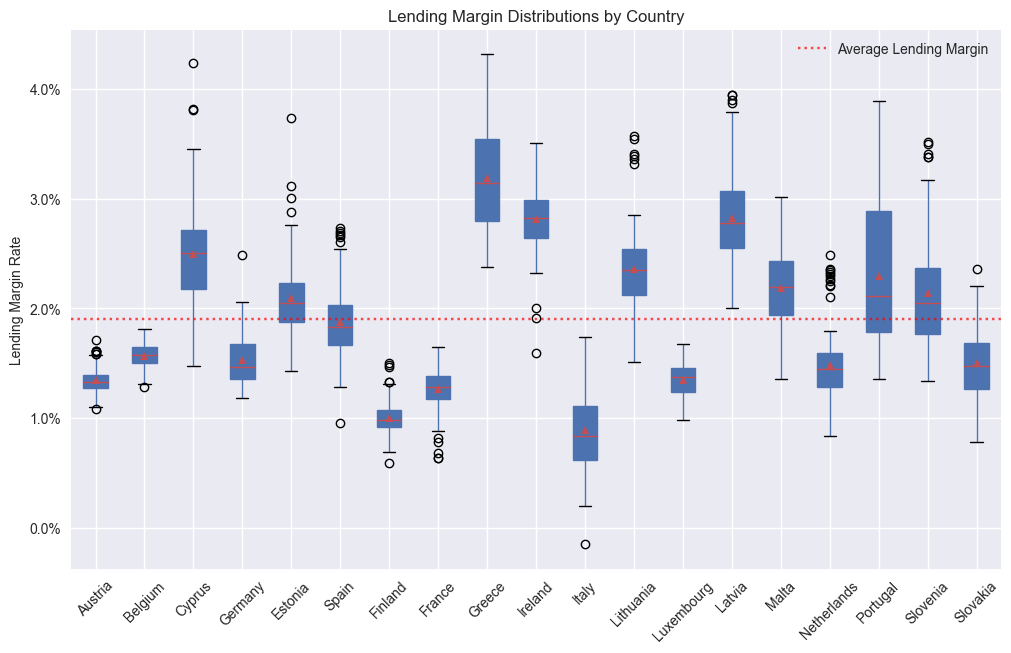

In [257]:
fig, ax = plt.subplots(1, 1, figsize=(12,7))
margins.drop(columns='EU_average').boxplot(ax=ax, patch_artist=True, showmeans = True)
ax.set_title('Lending Margin Distributions by Country')
ax.set_ylabel('Lending Margin Rate')
ax.axhline(y=margins['EU_average'].mean(), color='red', linestyle=':', label='Average Lending Margin', alpha=0.7)
vals = ax.get_yticks()/100
ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
ax.tick_params(axis='x', labelrotation=45)
plt.legend()
plt.show()

/var/folders/y1/w89cf9v14zb9dn4l_yrgzfth0000gn/T/ipykernel_1067/3044197746.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])


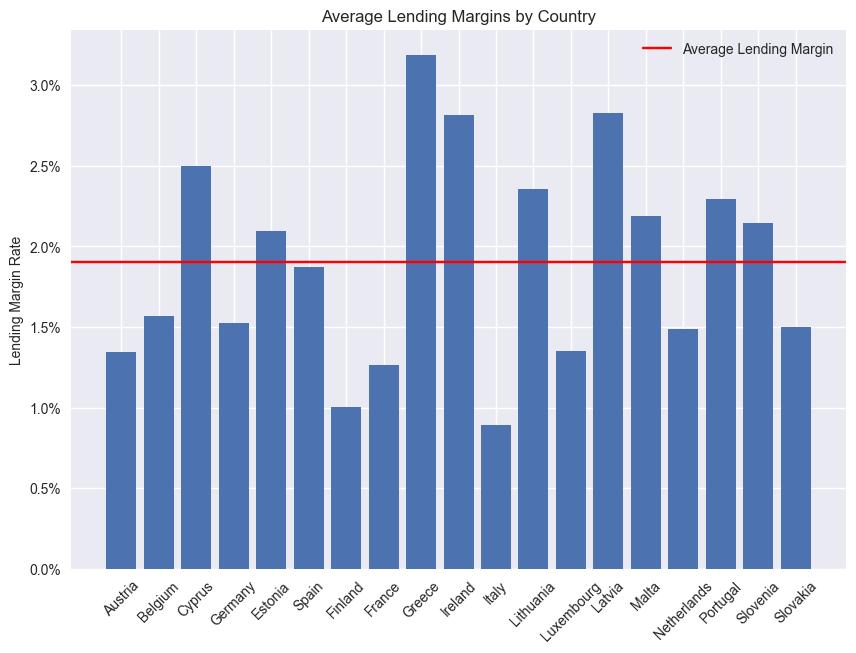

In [258]:
mean_margins = margins.drop('EU_average', axis=1).mean()

fig, ax = plt.subplots(1, 1, figsize=(10,7))
ax.bar(mean_margins.index, mean_margins)
ax.set_title('Average Lending Margins by Country')
ax.set_ylabel('Lending Margin Rate')
ax.tick_params(axis='x', labelrotation=45)
ax.axhline(y=margins['EU_average'].mean(), color='red', linestyle='-', label='Average Lending Margin')
vals = ax.get_yticks()/100
ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
plt.legend()
plt.show()

/var/folders/y1/w89cf9v14zb9dn4l_yrgzfth0000gn/T/ipykernel_1067/3374691262.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])


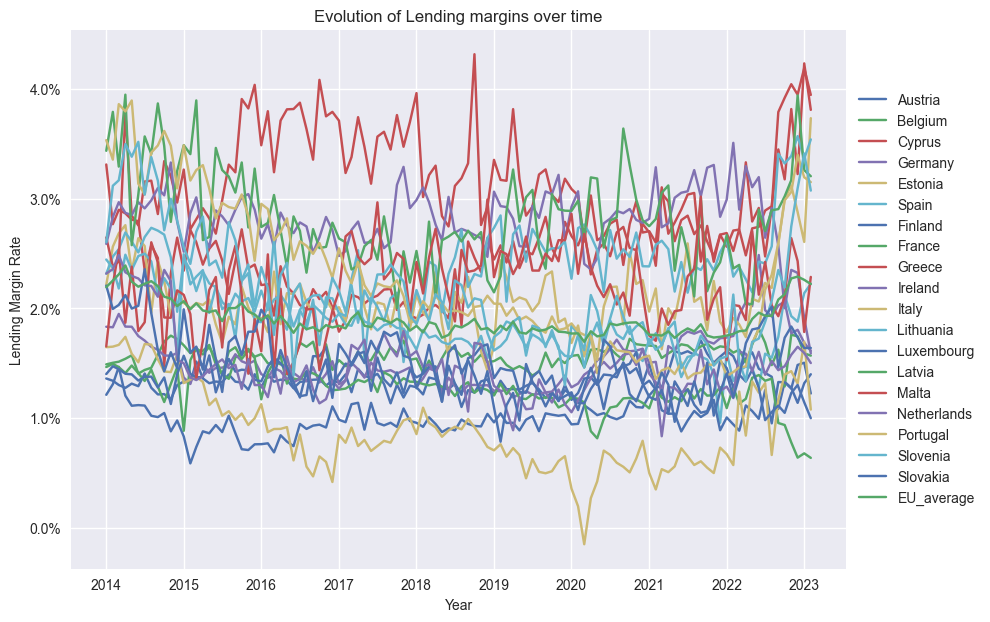

In [259]:
# Random

fig, ax = plt.subplots(1, 1, figsize=(10,7))
ax.plot(margins.loc[:, margins.columns], 
        label=['Austria', 'Belgium', 'Cyprus', 'Germany', 'Estonia', 'Spain', 'Finland', 'France', 'Greece', 'Ireland', 'Italy', 'Lithuania',
       'Luxembourg', 'Latvia', 'Malta', 'Netherlands', 'Portugal', 'Slovenia', 'Slovakia', 'EU_average'])
ax.set_ylabel('Lending Margin Rate')
ax.set_xlabel('Year')
ax.set_title('Evolution of Lending margins over time')
vals = ax.get_yticks()/100
ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

/var/folders/y1/w89cf9v14zb9dn4l_yrgzfth0000gn/T/ipykernel_1067/1082095611.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])


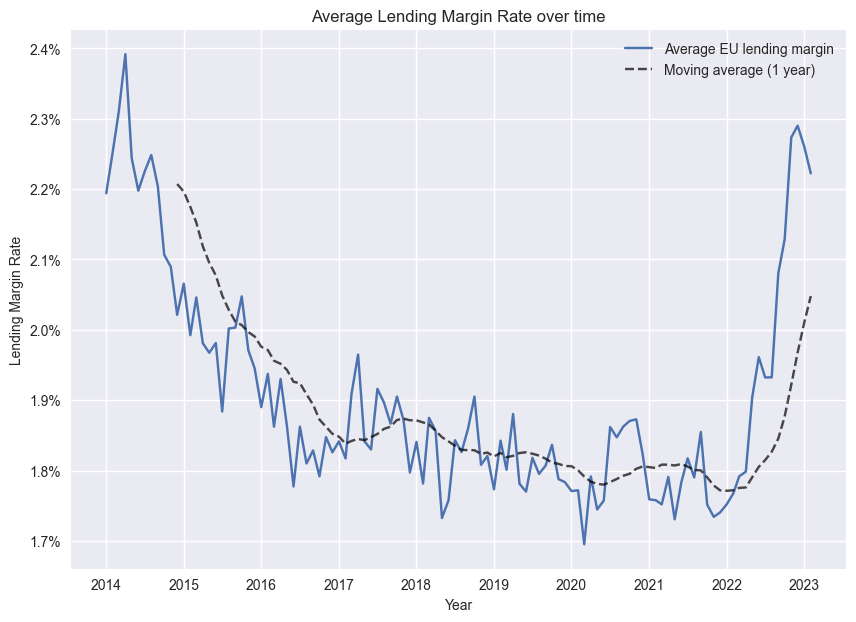

In [260]:
fig, ax = plt.subplots(1, 1, figsize=(10,7))
ax.plot(margins['EU_average'], label = 'Average EU lending margin')
ax.plot(margins.rolling(window=12).mean()['EU_average'], color ="black", linestyle='dashed', alpha= 0.7, label = 'Moving average (1 year)')
ax.set_ylabel('Lending Margin Rate')
ax.set_xlabel('Year')
ax.set_title('Average Lending Margin Rate over time')
vals = ax.get_yticks()/100
ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
plt.legend()
plt.show()

We note a similarity in trend with respect to the lending rates analyzed before: this confirms that the gathered data is correct.

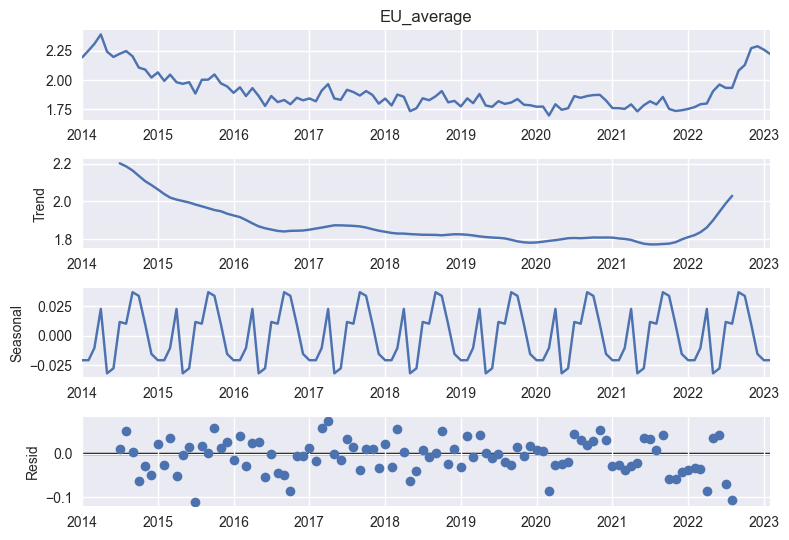

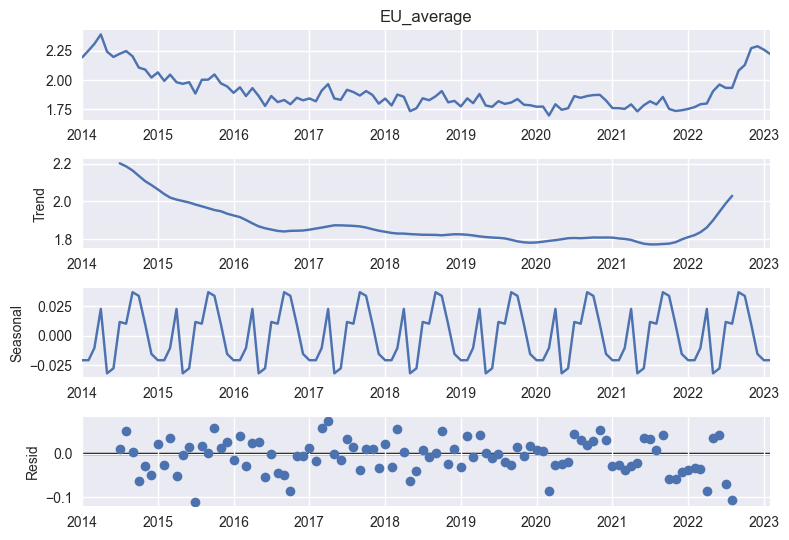

In [261]:
seasonal_decompose(margins['EU_average']).plot()

gradual decreasing trend with peak in last year, strange but present yearly seasonality